# Notebook CO2 emissions Agri-food Sector


In [202]:
# Install necessary packages 
!pip install scikit-optimize
!pip install shap

# General data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Statistics and data transformation
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import chi2

# Machine learning - preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer

# Machine learning - dimensionality reduction
from sklearn.decomposition import PCA

# Machine learning - modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Model evaluation and validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold

# Optimization and hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeltaYStopper

# Explainability tools
import shap

## 1. Exploratory Data Analysis

In [203]:
# Loading the data
data = pd.read_csv("Agrofood_co2_emission.csv")
data.info()
data.describe()

# Unique data points of Area
data['Area'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-null   float64
 11  Food Household Consumption       6492 non-null   float64
 12  Food Retail         

236

In [204]:
# Range target variable
range_C02_emissions = data['total_emission'].max() - data['total_emission'].min()
print(range_C02_emissions)

3506997.8046999993


### Distribution Plots

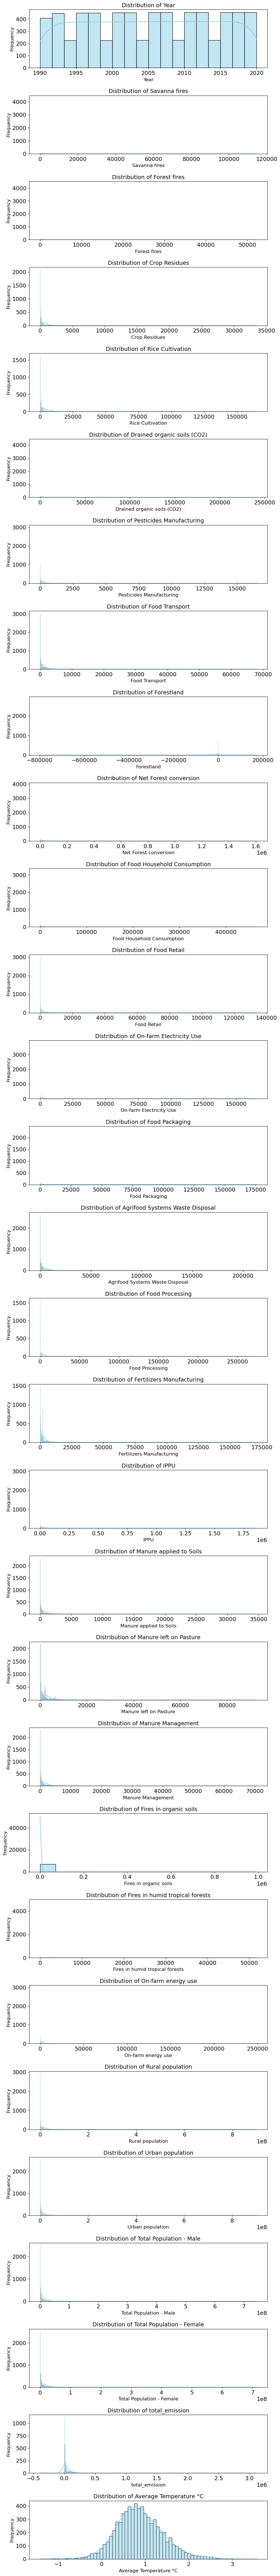

In [205]:
# Distribution numeric features
# Select numeric columns
columns_n = data.select_dtypes(include=['float64', 'int64']).columns
features_n = len(columns_n)

# Set up the figure with subplots for each feature
fig, axes = plt.subplots(features_n, 1, figsize=(10, features_n * 3))

# Plot each feature with histogram and KDE line
for i, col in enumerate(columns_n):
    sns.histplot(data[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

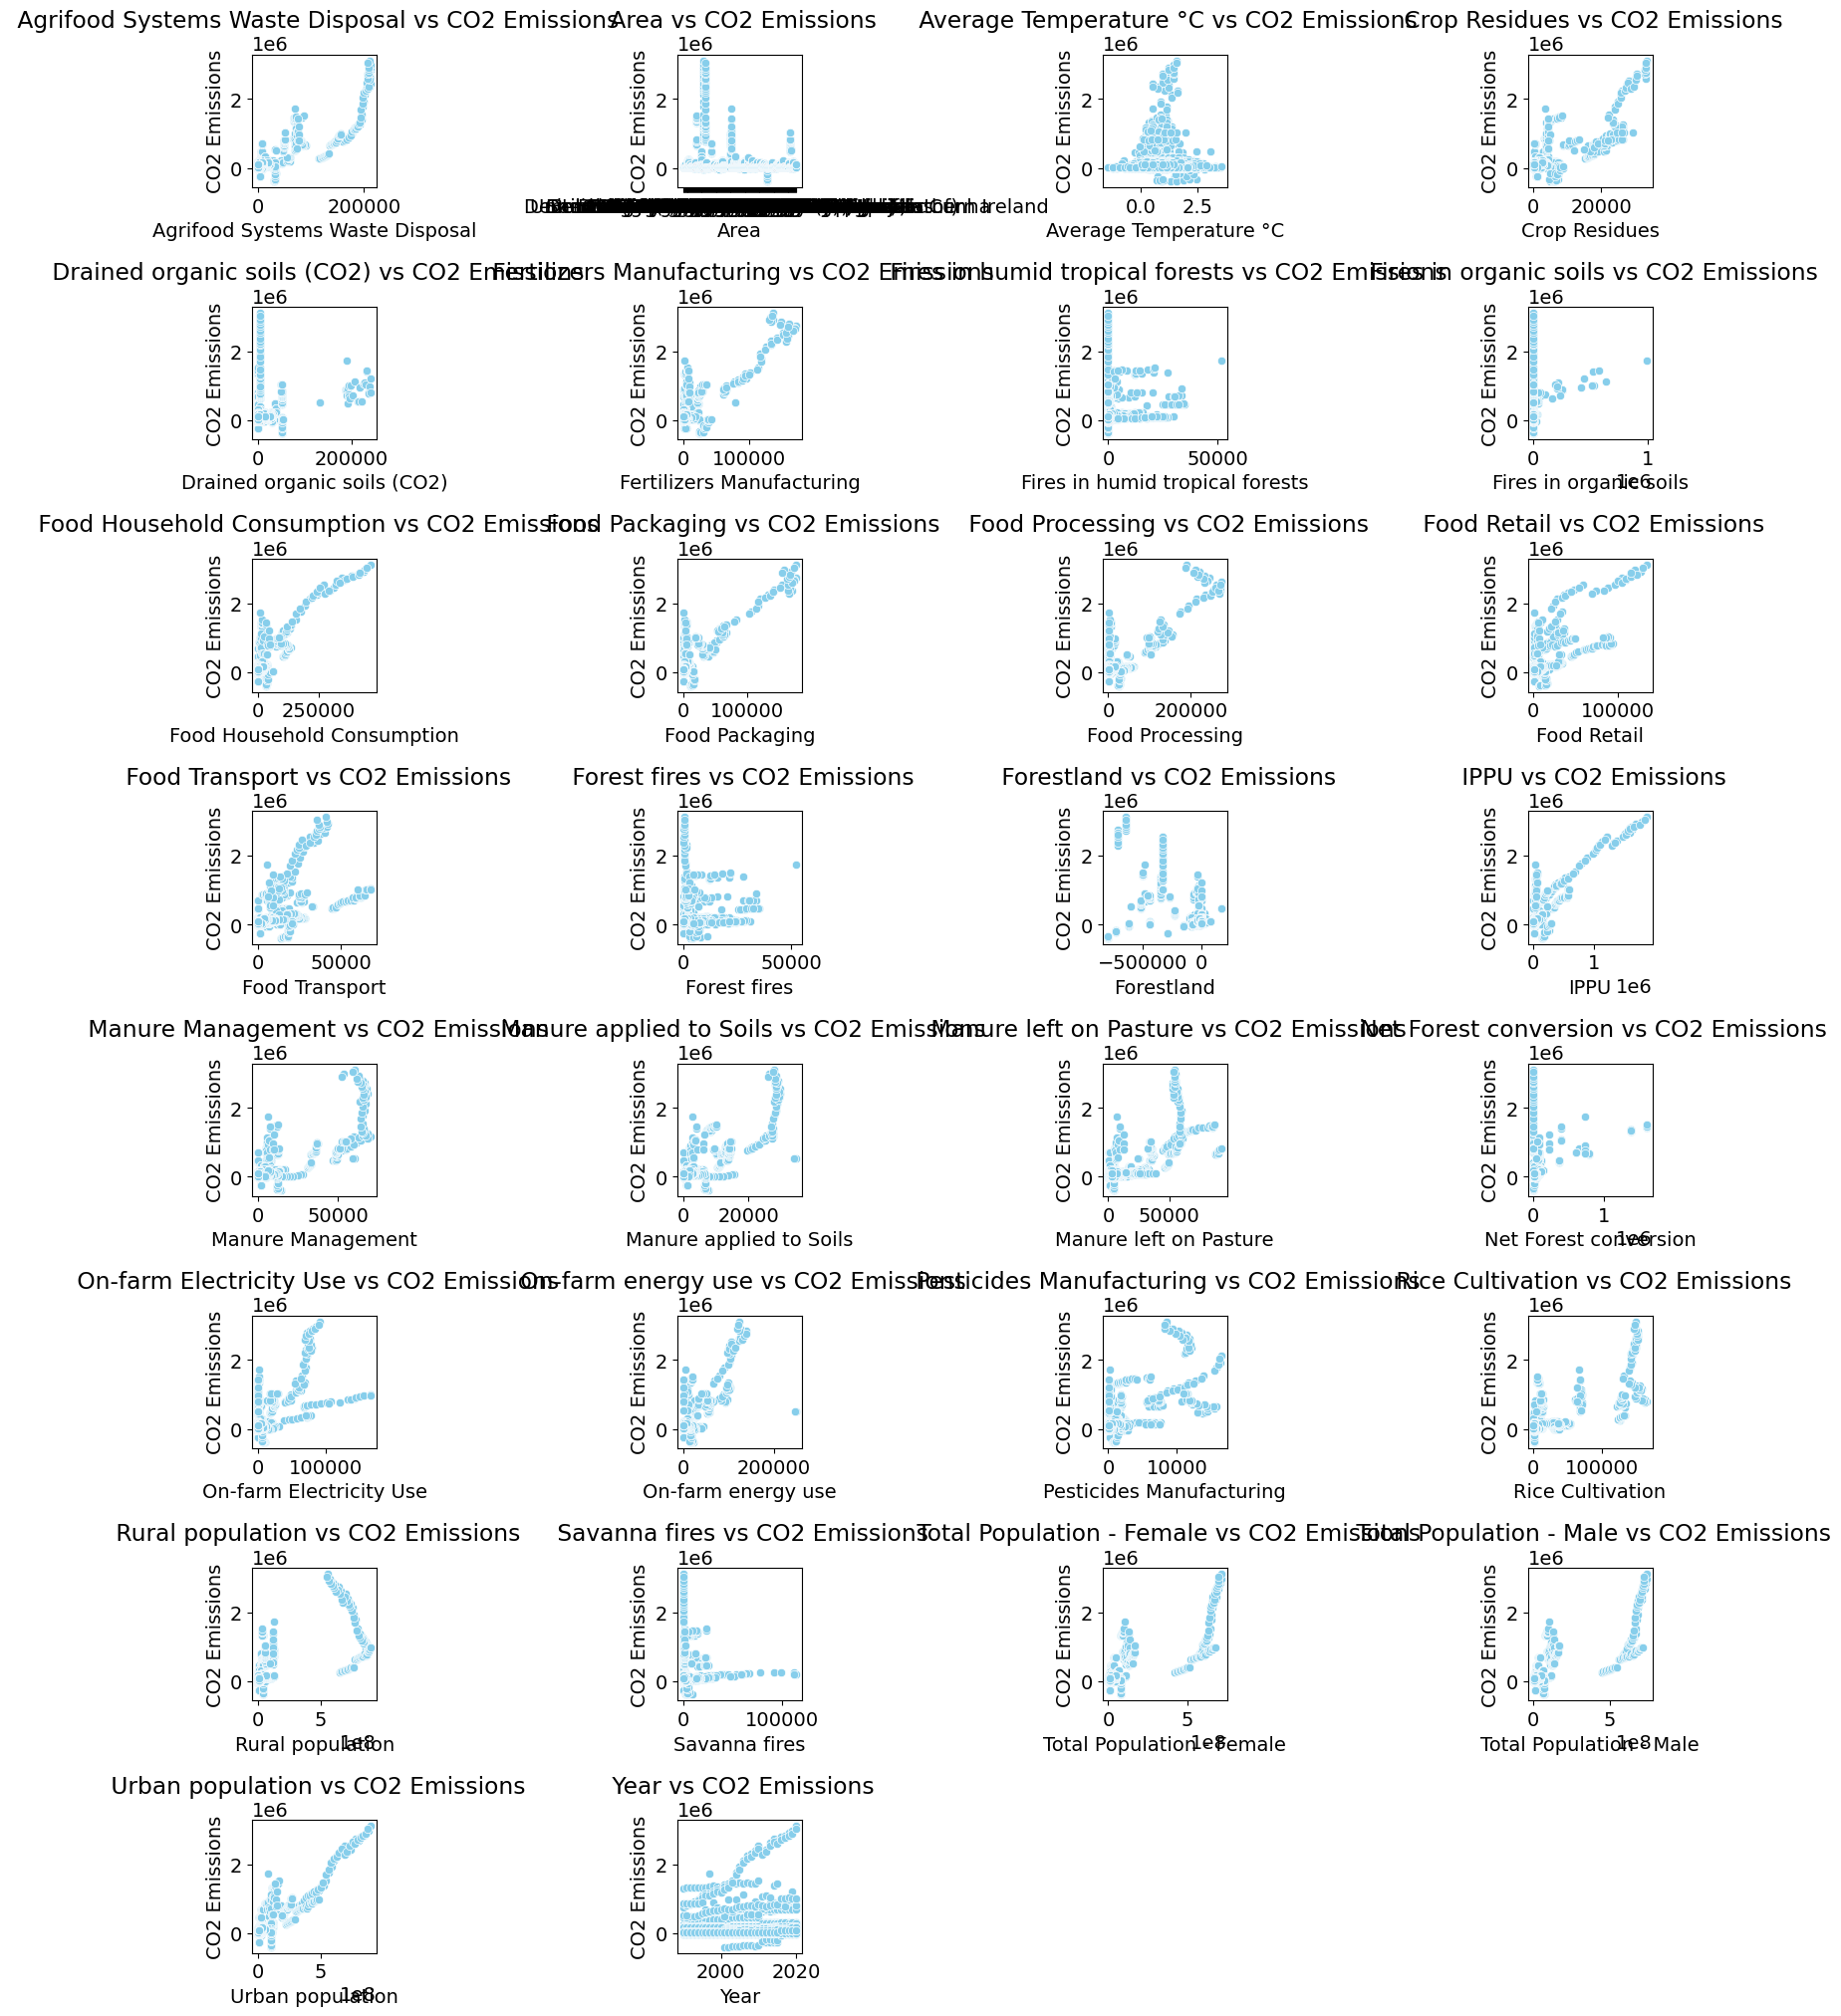

In [206]:
# Features to plot against the Total Emission
independent_vars = data.columns.difference(['total_emission'])

# Scatterplot
plt.figure(figsize=(15, 25))  

for i, var in enumerate(independent_vars):
    plt.subplot(10, 4, i + 1)  
    sns.scatterplot(x=data[var], y=data['total_emission'], color= 'skyblue', marker= 'o')
    plt.title(f' {var} vs CO2 Emissions')
    plt.xlabel(var)
    plt.ylabel('CO2 Emissions')

plt.tight_layout()
plt.show()


In [207]:
# Distribution plot categoric feature 'Area':
distribution_area = data['Area'].value_counts()
print(distribution_area)

Afghanistan                        31
Isle of Man                        31
Montserrat                         31
Morocco                            31
Mozambique                         31
                                   ..
Czechoslovakia                      3
Ethiopia PDR                        3
USSR                                2
Yugoslav SFR                        2
Pacific Islands Trust Territory     1
Name: Area, Length: 236, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5 

In [208]:
# Count unique countries
unique_countries = data['Area'].nunique()

# Count how many areas have exactly 31 values
count_31_values = data['Area'].value_counts()[data['Area'].value_counts() == 31].count()

print(f"Number of unique countries: {unique_countries}")
print(f"Number of areas with exactly 31 observations: {count_31_values}")

Number of unique countries: 236
Number of areas with exactly 31 observations: 194


Category with max observations: Afghanistan (31 observations)



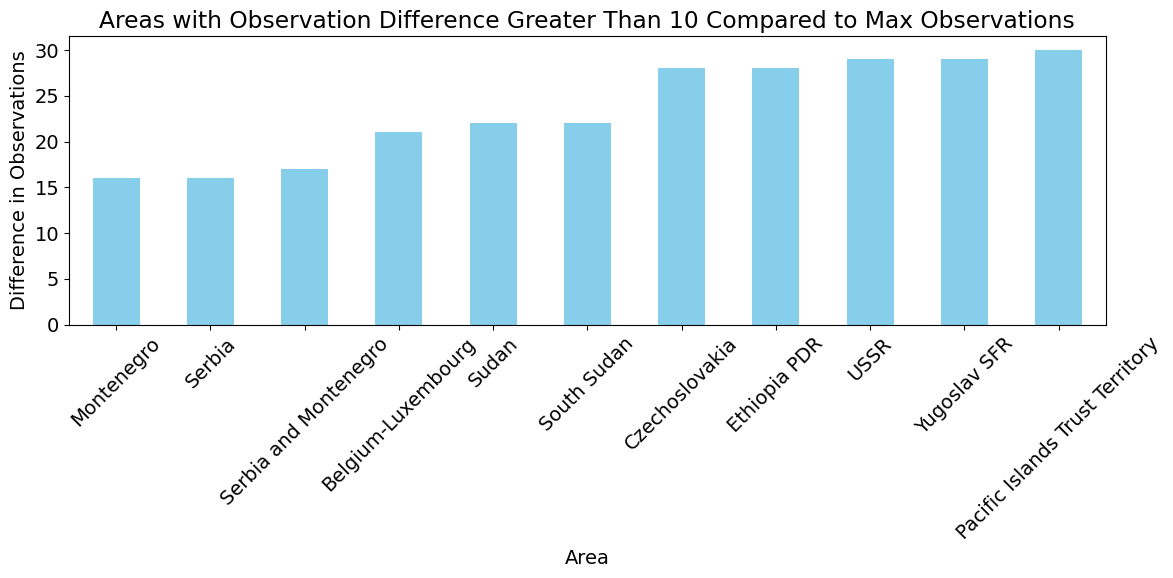

In [209]:
# Class imbalance in 'Area' feature?
# Identify the 'Area' category with the maximum observations
max_category = data['Area'].value_counts().idxmax()
max_category_count = data['Area'].value_counts().max()

print(f"Category with max observations: {max_category} ({max_category_count} observations)\n")
       
# Calculate differences and filter areas with a difference greater than 10
area_counts = data['Area'].value_counts()
diff_counts = area_counts.apply(lambda x: max_category_count - x)
diff_counts = diff_counts[diff_counts > 10]

# Plot the results
plt.figure(figsize=(12, 6))
diff_counts.plot(kind='bar', color='skyblue')
plt.title('Areas with Observation Difference Greater Than 10 Compared to Max Observations')
plt.xlabel('Area')
plt.ylabel('Difference in Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlation Matrix (Multivariate analysis)

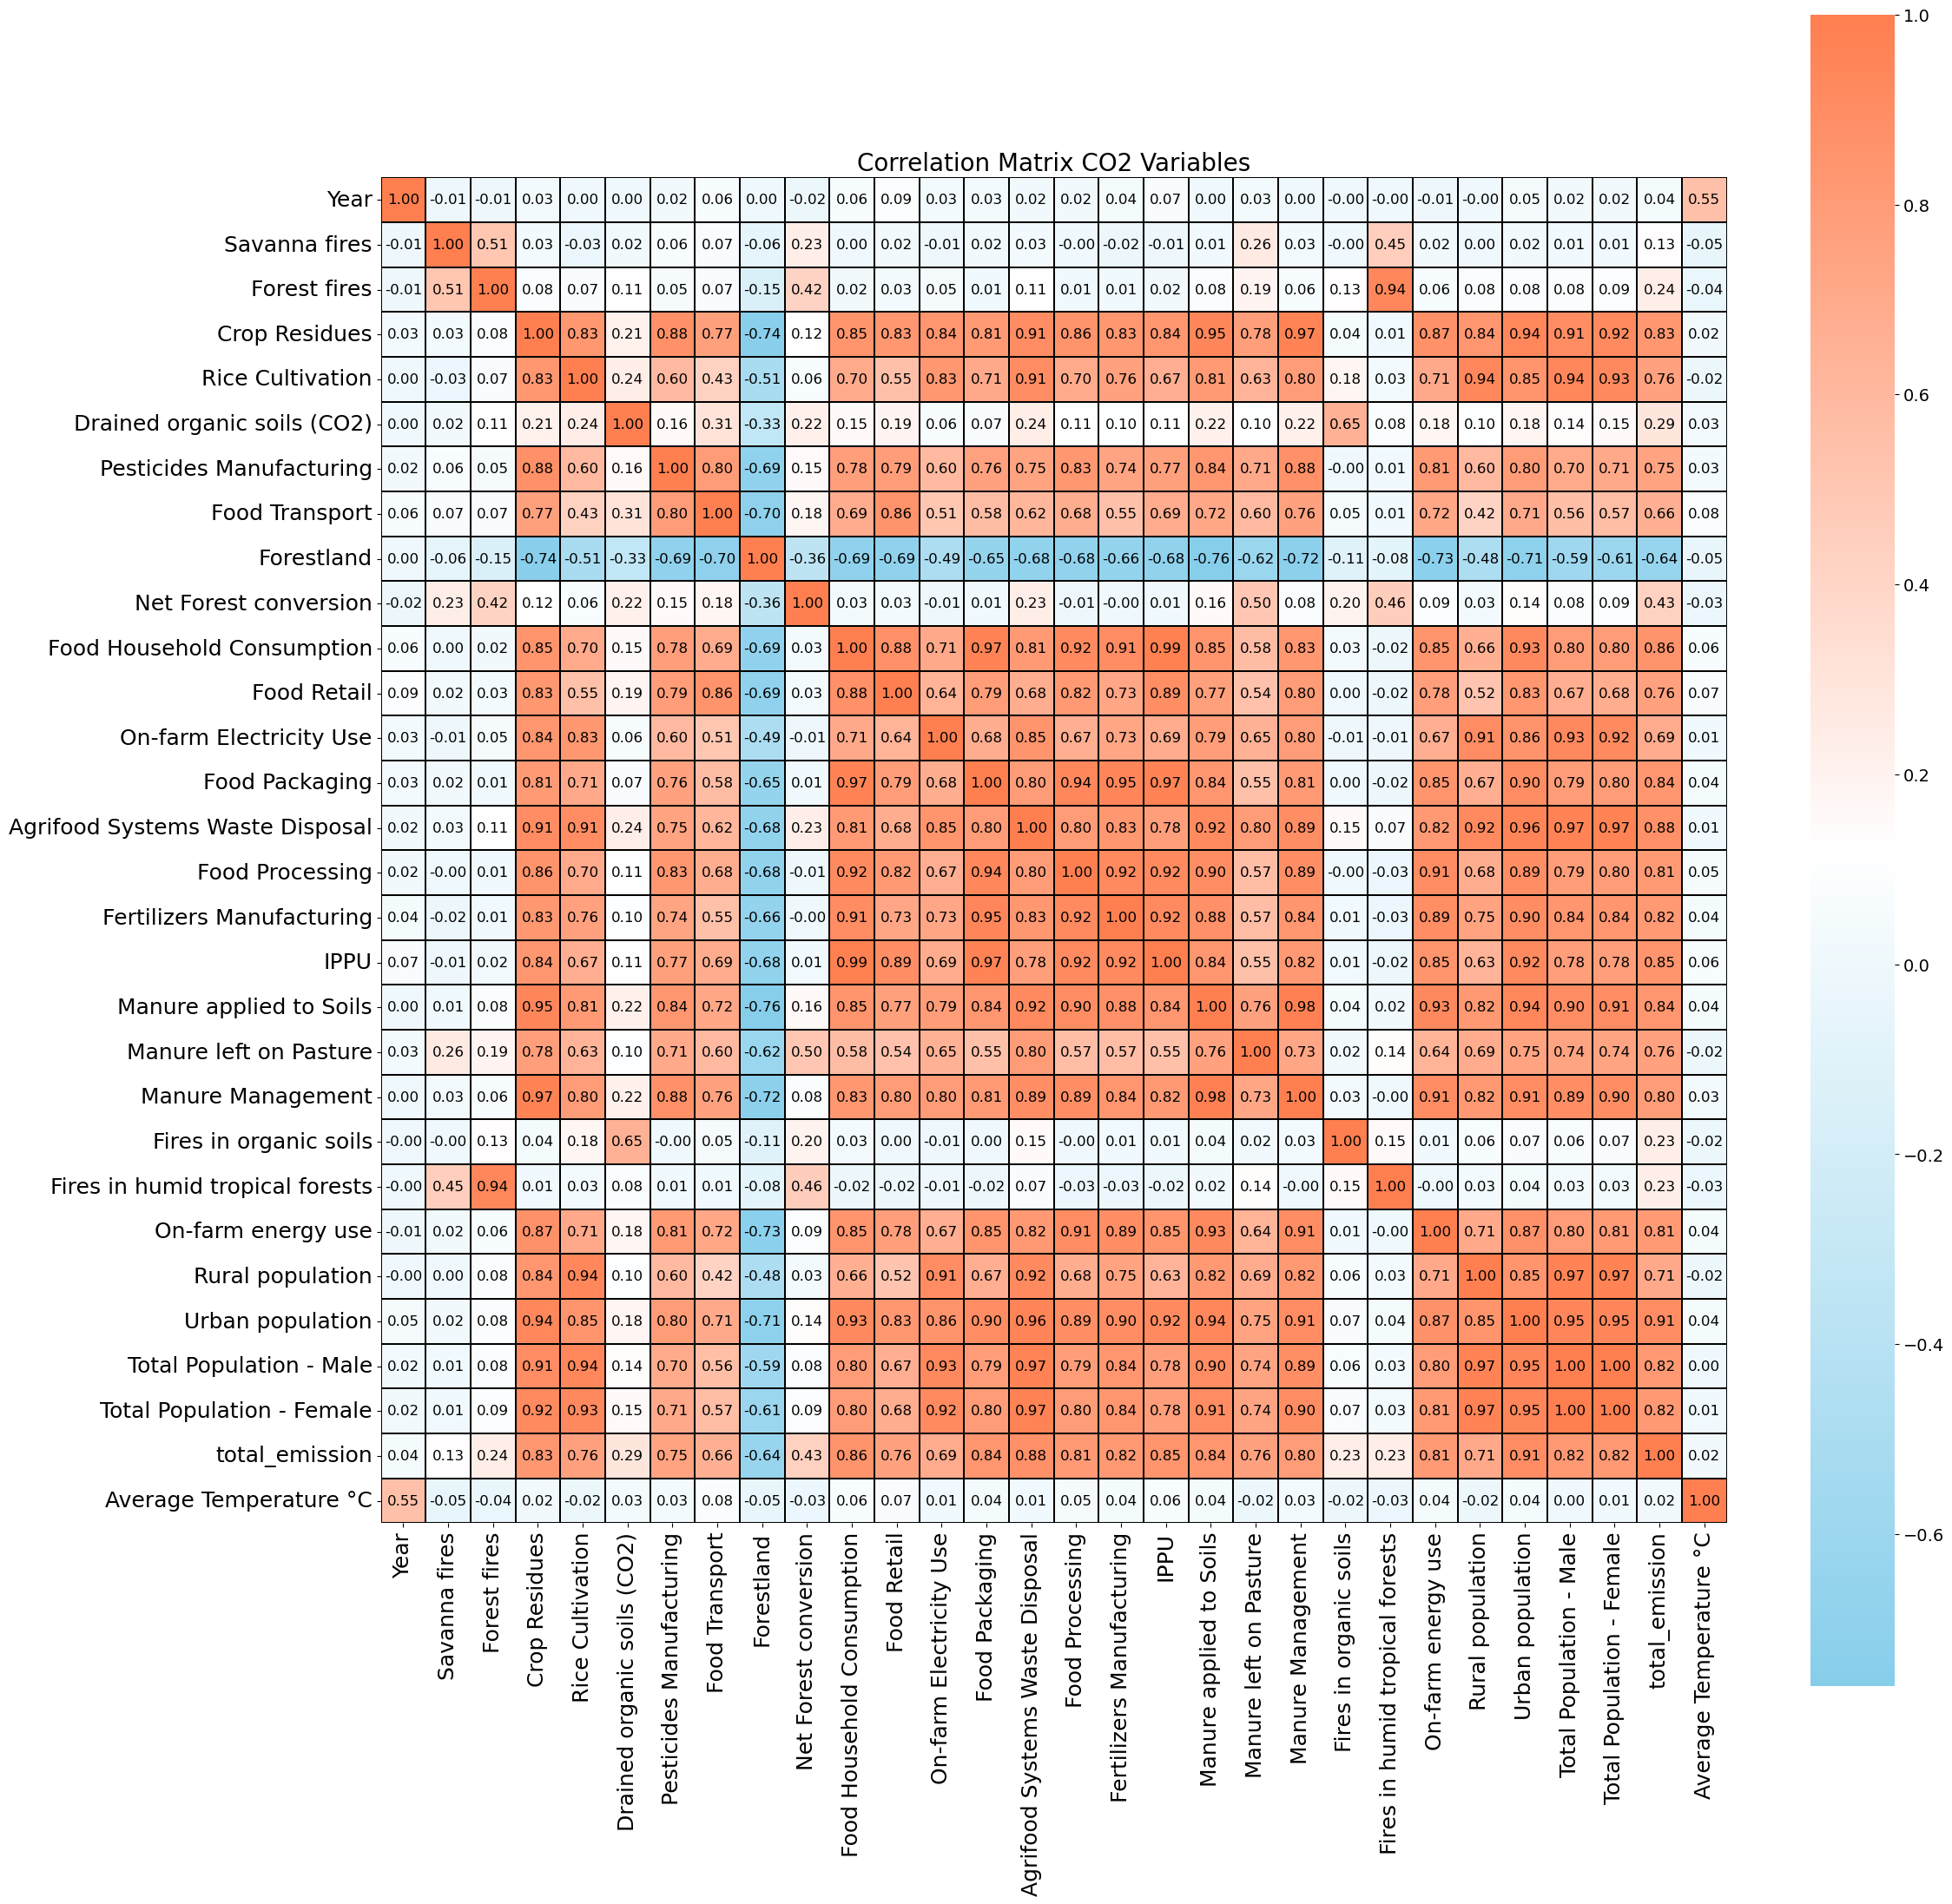

In [222]:
correlation_matrix = data.corr(method = 'pearson',numeric_only= True).round(2)

# Custom colormap
cmap = LinearSegmentedColormap.from_list(
    "Custom", ["#87CEEB", "white", "#FF7F50"]
)

plt.figure(figsize= (25,25))       
sns.heatmap(correlation_matrix.round(2), annot= True, cmap= cmap, fmt= '.2f', linewidths= 0.3,  linecolor='black', square= True, annot_kws={"size": 12, "color": "black"})  

plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.title("Correlation Matrix CO2 Variables", fontsize = 20)
plt.savefig('Correlation Matrix CO2 Variables', bbox_inches='tight')
plt.show()

In [211]:
# Pearson correlation between total_emission and other features:
total_emission_correlations = correlation_matrix['total_emission']
print(total_emission_correlations)

On_farm_electricity_use = correlation_matrix['On-farm Electricity Use']
print(On_farm_electricity_use)

Year                               0.04
Savanna fires                      0.13
Forest fires                       0.24
Crop Residues                      0.83
Rice Cultivation                   0.76
Drained organic soils (CO2)        0.29
Pesticides Manufacturing           0.75
Food Transport                     0.66
Forestland                        -0.64
Net Forest conversion              0.43
Food Household Consumption         0.86
Food Retail                        0.76
On-farm Electricity Use            0.69
Food Packaging                     0.84
Agrifood Systems Waste Disposal    0.88
Food Processing                    0.81
Fertilizers Manufacturing          0.82
IPPU                               0.85
Manure applied to Soils            0.84
Manure left on Pasture             0.76
Manure Management                  0.80
Fires in organic soils             0.23
Fires in humid tropical forests    0.23
On-farm energy use                 0.81
Rural population                   0.71


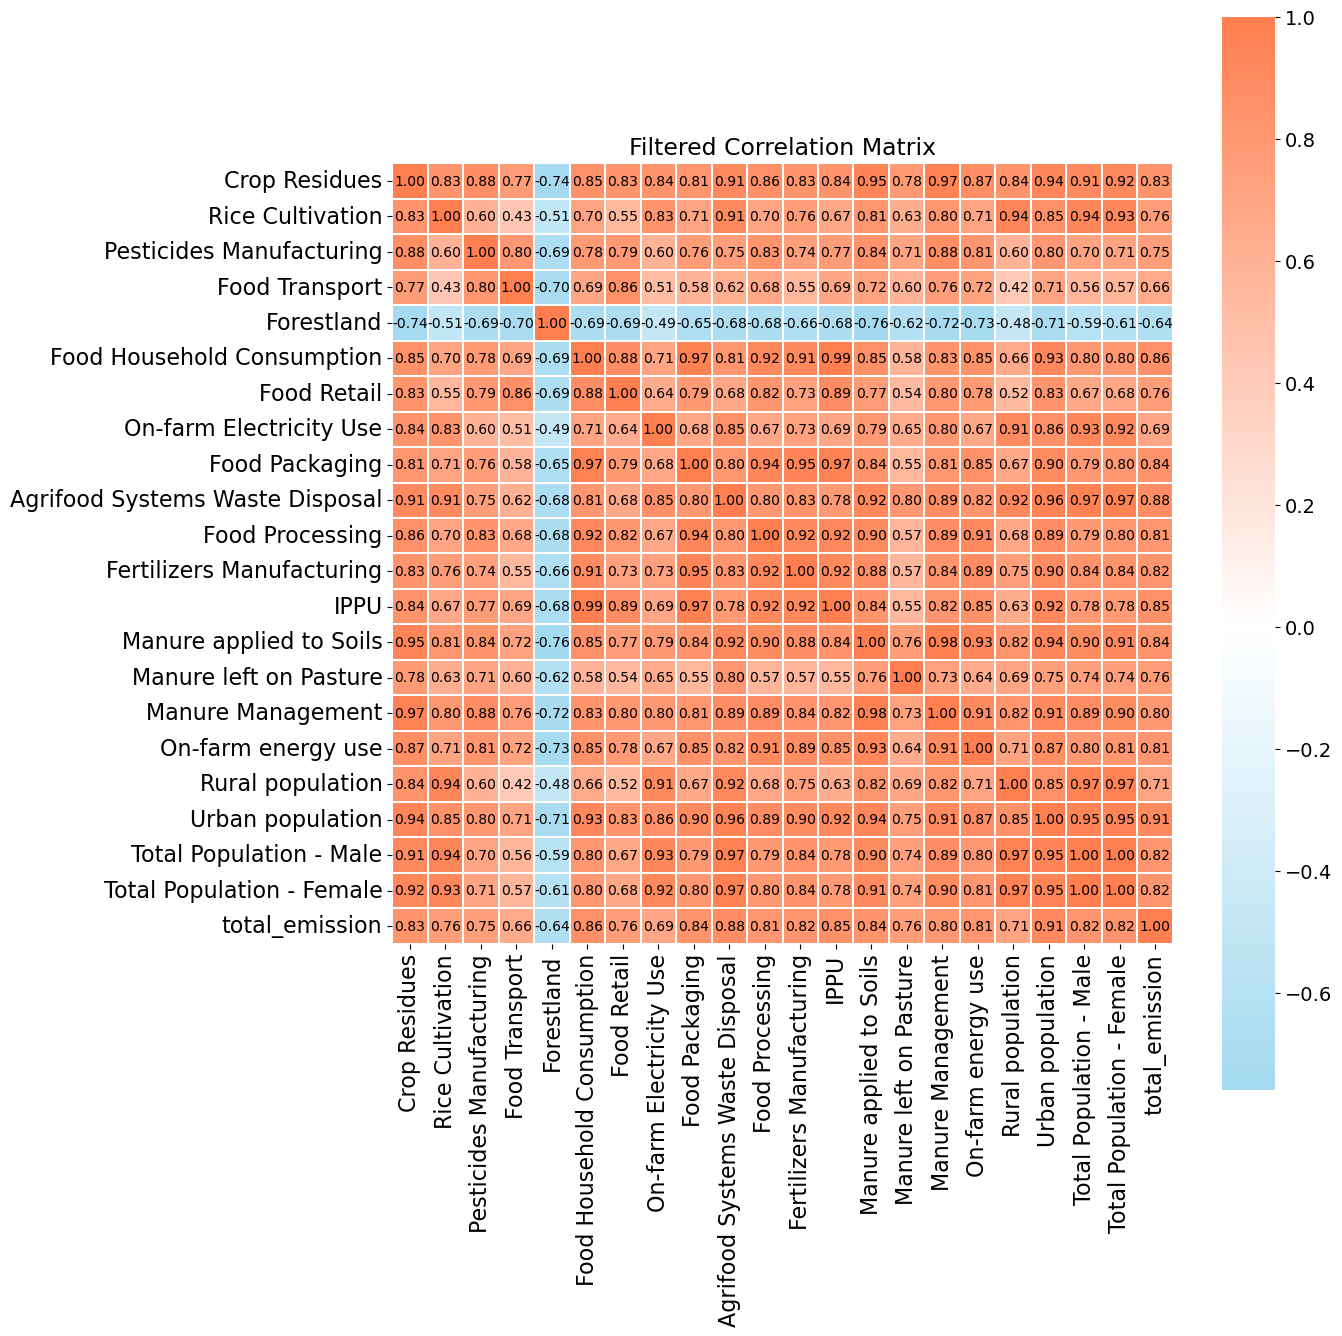

In [220]:
# Filter correlation with total_emission > 0.5 or < -0.5
significant_correlations = total_emission_correlations[
    (total_emission_correlations > 0.5) | (total_emission_correlations < -0.5)
]
selected_features = significant_correlations.index

# Correlatiematrix with selected features
reduced_correlation_matrix = correlation_matrix.loc[selected_features, selected_features]

cmap = LinearSegmentedColormap.from_list(
    "Custom", ["#87CEEB", "white", "#FF7F50"]
)

# Plot the correlation matrix
plt.figure(figsize=(14, 14))  
sns.heatmap(
    reduced_correlation_matrix, 
    annot=True, 
    cmap= cmap,  
    fmt='.2f', 
    linewidths=0.3, 
    square=True, 
    annot_kws={"size": 10,"color": "black"},
    center=0
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Filtered Correlation Matrix", fontsize=17)
plt.tight_layout()
plt.savefig('Reduced_Correlation_Matrix_Reversed.png', dpi=300)  
plt.show()


In [213]:
# Correlation > 0.8
filtered_correlations = total_emission_correlations[total_emission_correlations > 0.8]
print(filtered_correlations)

Crop Residues                      0.83
Food Household Consumption         0.86
Food Packaging                     0.84
Agrifood Systems Waste Disposal    0.88
Food Processing                    0.81
Fertilizers Manufacturing          0.82
IPPU                               0.85
Manure applied to Soils            0.84
On-farm energy use                 0.81
Urban population                   0.91
Total Population - Male            0.82
Total Population - Female          0.82
total_emission                     1.00
Name: total_emission, dtype: float64


### Data Quality Issues

Savanna fires                       0.445083
Forest fires                        1.335248
Crop Residues                      19.942570
Forestland                          7.078248
Net Forest conversion               7.078248
Food Household Consumption          6.791098
IPPU                               10.667624
Manure applied to Soils            13.323762
Manure Management                  13.323762
Fires in humid tropical forests     2.225413
On-farm energy use                 13.725772
dtype: float64


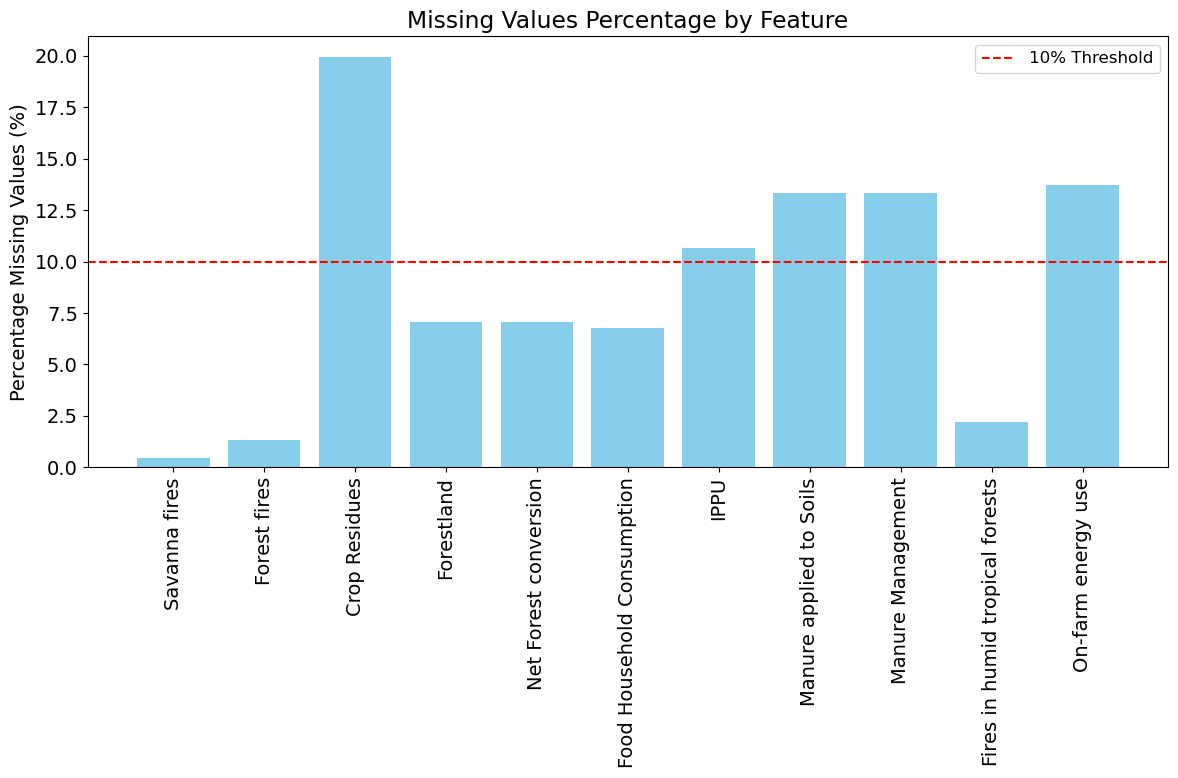

In [147]:
# Missing values within the dataset:
N_missingvalues = data.isnull().sum()
R_missingvalues = data.isnull().mean() * 100

# Which specific features has missing values?
R_missingvalues = R_missingvalues[R_missingvalues > 0]

print(R_missingvalues)

# Plot % of missing values
plt.figure(figsize=(12, 8))
plt.bar(R_missingvalues.index, R_missingvalues.values, color='skyblue')
plt.axhline(y=10, color='r', linestyle='--', label='10% Threshold')
plt.ylabel('Percentage Missing Values (%)')
plt.title('Missing Values Percentage by Feature')
plt.xticks(rotation= 90, fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout() 
plt.savefig('missingvalues_plot.png')
plt.show()

In [138]:
#MCAR
# Calculate observed missing patterns
missing_patterns = data.isnull().astype(int)
pattern_counts = missing_patterns.value_counts()

# Create expected frequencies assuming MCAR
expected_counts = np.full_like(pattern_counts, fill_value=np.mean(pattern_counts))

# Chi-square statistic
chi_square_stat = np.sum((pattern_counts - expected_counts)**2 / expected_counts)

# Degrees of freedom
df = len(pattern_counts) - 1

# P-value
p_value = chi2.sf(chi_square_stat, df)

# Results
print(f"Chi-square Statistic: {chi_square_stat}, p-value: {p_value}")
if p_value > 0.05:
    print("Data is MCAR (Missing Completely At Random).")
else:
    print("Data is not MCAR.")

Chi-square Statistic: 105703.45212765958, p-value: 0.0
Data is not MCAR.


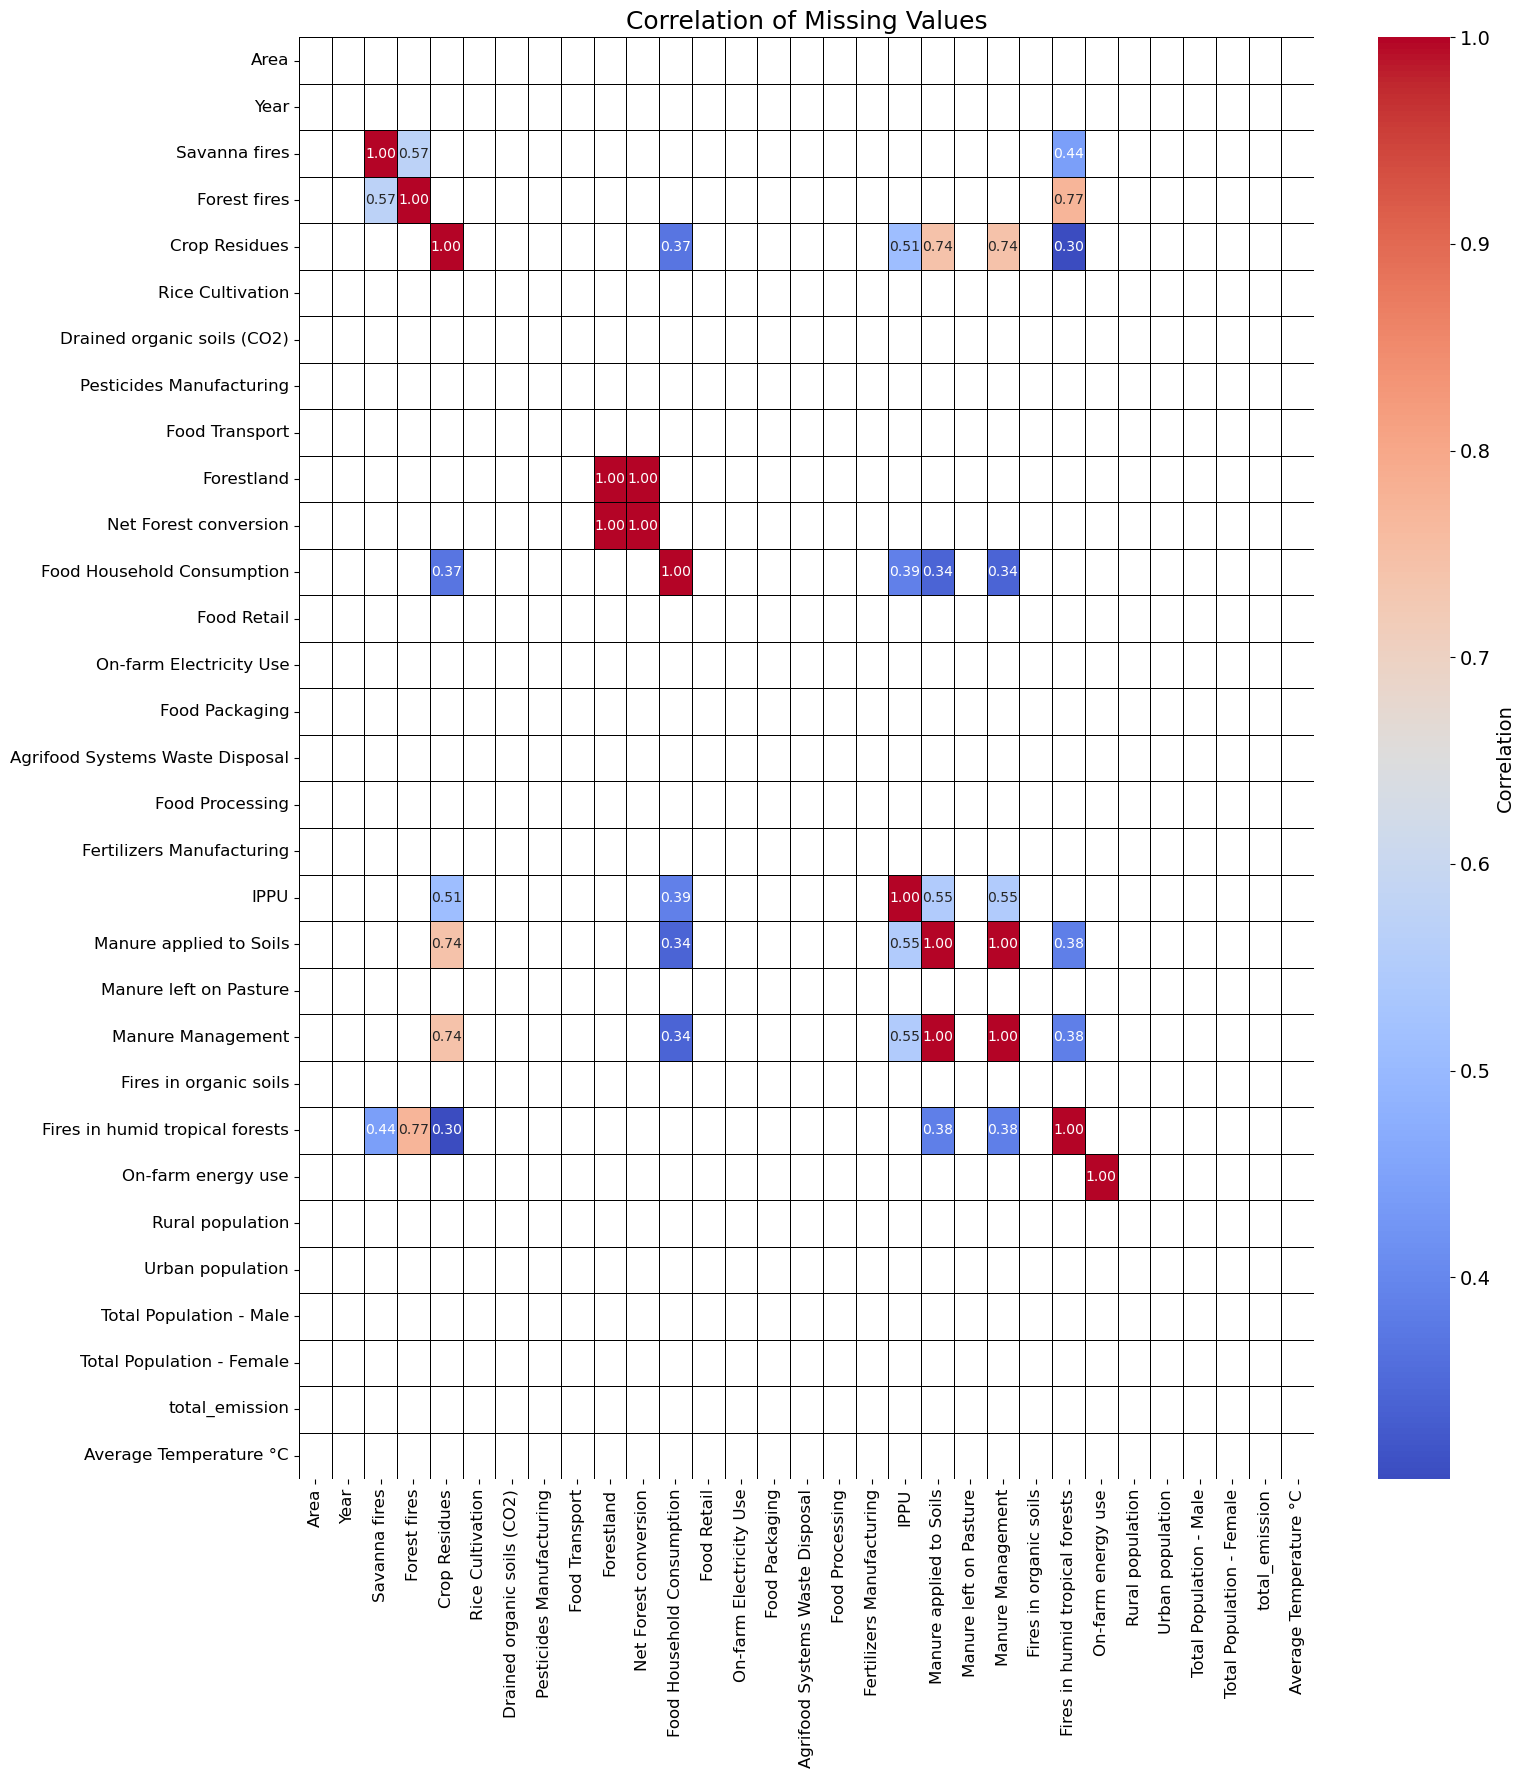

In [152]:
# MAR
# Calculate correlation matrix for missingness
plt.figure(figsize=(16, 18)) 
mask = correlation_matrix.abs() < 0.3  # Mask correlations below 0.3
sns.heatmap(
    correlation_matrix, 
    mask=mask,  
    annot=True, 
    fmt=".2f",  
    cmap='coolwarm', 
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'label': 'Correlation'},  # Label for color bar
    annot_kws={"size": 10}  
)
plt.title('Correlation of Missing Values', fontsize=18)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('missing_values_correlation_improved.png')  
plt.show()

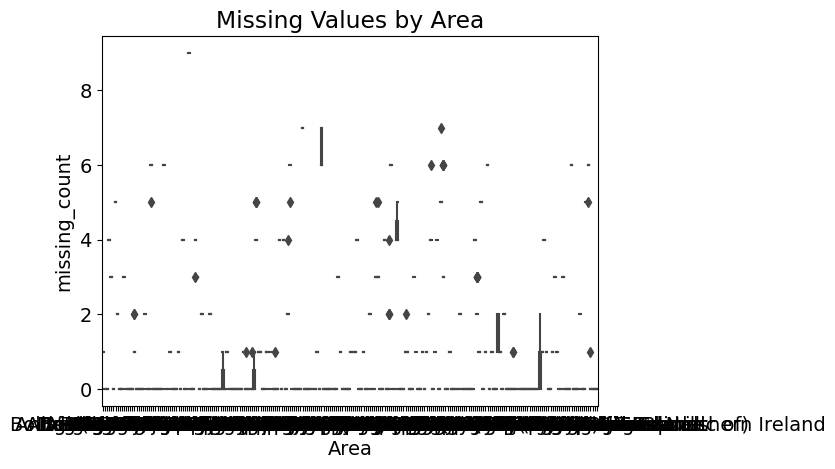

In [146]:
data['missing_count'] = data.isnull().sum(axis=1)
sns.boxplot(x='Area', y='missing_count', data=data)
plt.title('Missing Values by Area')
plt.savefig('missing_values_by_area.png')
plt.show()

Summary of rows with missing 'Crop Residues':
              Year  Savanna fires  Forest fires  Crop Residues  \
count  1389.000000    1358.000000   1296.000000            0.0   
mean   2005.036717       0.020329      0.031347            NaN   
std       8.923592       0.137496      0.258851            NaN   
min    1990.000000       0.000000      0.000000            NaN   
25%    1997.000000       0.000000      0.000000            NaN   
50%    2005.000000       0.000000      0.000000            NaN   
75%    2013.000000       0.000000      0.000000            NaN   
max    2020.000000       1.972700      5.694800            NaN   

       Rice Cultivation  Drained organic soils (CO2)  \
count       1389.000000                  1389.000000   
mean        2569.868421                   123.637992   
std         2705.272154                   815.513699   
min            0.000000                     0.000000   
25%          921.664109                     0.000000   
50%         1639.724833

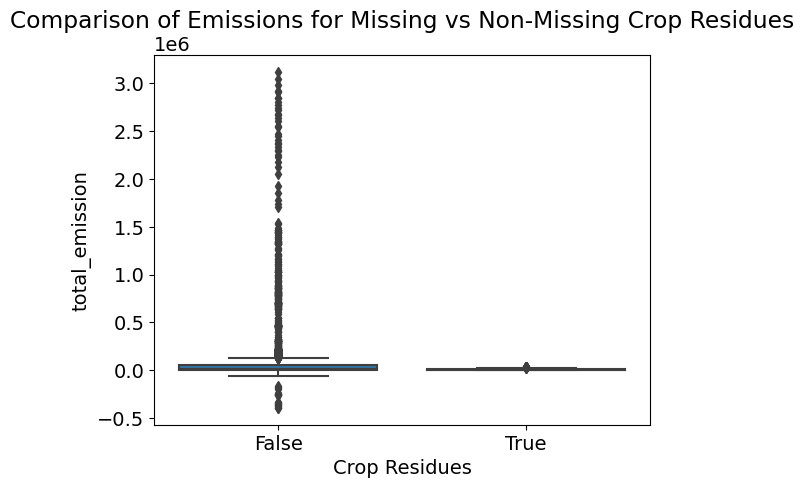

In [153]:
# MNAR
# Analyze rows with missing values
missing_rows = data[data['Crop Residues'].isnull()]
non_missing_rows = data[~data['Crop Residues'].isnull()]

# Summary statistics
print("Summary of rows with missing 'Crop Residues':")
print(missing_rows.describe())

print("Summary of rows without missing 'Crop Residues':")
print(non_missing_rows.describe())

sns.boxplot(x=data['Crop Residues'].isnull(), y=data['total_emission'])
plt.title('Comparison of Emissions for Missing vs Non-Missing Crop Residues')
plt.savefig('comparisonmissingornonmissingcrop.png')  
plt.show()

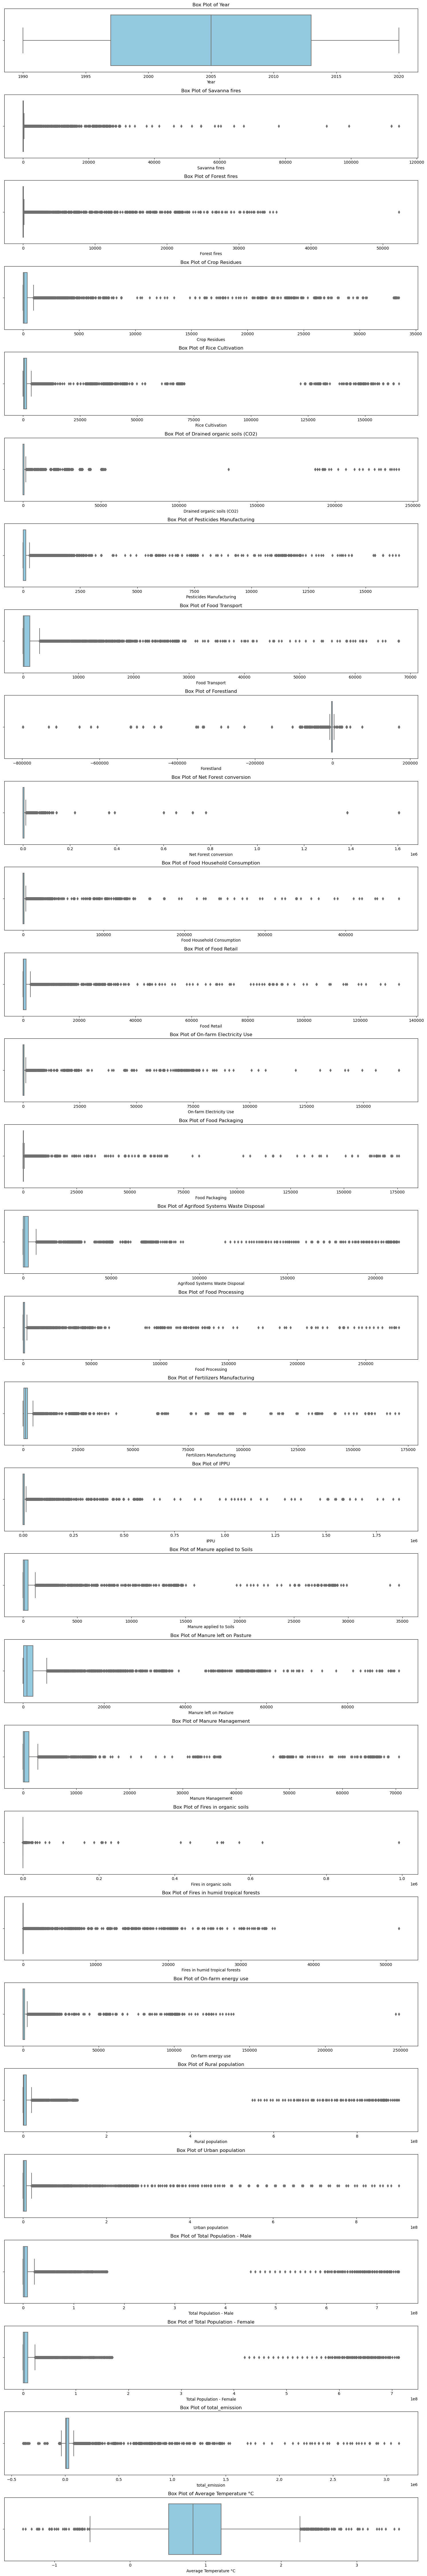

In [16]:
# Outliers within the dataset:
# Plot box plots for all numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, len(numeric_features) * 3))

for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 1, i + 1)
    sns.boxplot(x=data[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

In [17]:
# Function to calculate the Median Absolute Deviation (MAD)
def mad(series):
    return np.median(np.abs(series - np.median(series)))

# Calculate MAD for all numeric features
median = data[numeric_features].median()
mad_values = data[numeric_features].apply(mad)

# Calculate MAD scores for each value
mad_scores = data[numeric_features].sub(median).abs().div(mad_values)

# Identify rows where any feature has a MAD score above a threshold (e.g., > 3)
outliers = (mad_scores > 3).any(axis=1)
outliers_data = data[outliers]

# Count outliers per feature (MAD threshold > 3)
outlier_counts = (mad_scores > 3).sum()

# Count percentage per feature
outlier_percentages = (outlier_counts / len(data)) * 100

# Dataframe with outlier counts and percentages
outlier_stats_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'Outlier_Count': outlier_counts.values,
    'Outlier_Percentage': outlier_percentages.values
})

# Features with outliers
outlier_stats_df = outlier_stats_df[outlier_stats_df['Outlier_Count'] > 0]

print(outlier_stats_df)

# Drained organic soils outlier? --> according to literature range till 100+ MtCO₂ per year

max_drained= data["Drained organic soils (CO2)"].max()
upper_limit = np.percentile(data["Drained organic soils (CO2)"], 99)
print("max drained =",  max_drained)
print("Upper limit of winsorizing =",  upper_limit)


                            Feature  Outlier_Count  Outlier_Percentage
4                  Rice Cultivation           1513           21.722900
5       Drained organic soils (CO2)           3112           44.680546
6          Pesticides Manufacturing           2368           33.998564
7                    Food Transport           2133           30.624551
11                      Food Retail           2152           30.897344
12          On-farm Electricity Use           2768           39.741565
13                   Food Packaging           1820           26.130653
14  Agrifood Systems Waste Disposal           1587           22.785355
15                  Food Processing           1915           27.494616
16        Fertilizers Manufacturing           1008           14.472362
19           Manure left on Pasture           1336           19.181622
21           Fires in organic soils            309            4.436468
24                 Rural population           2040           29.289304
25    

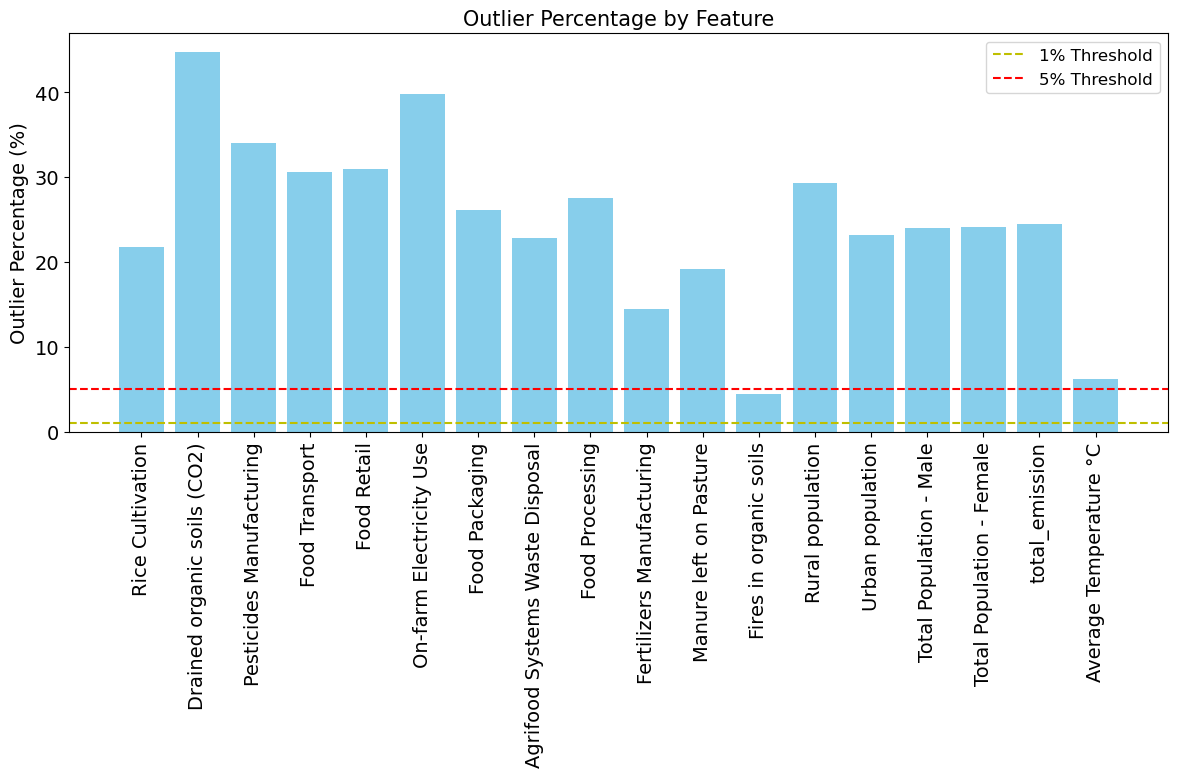

In [54]:
# Plot % of outliers
plt.figure(figsize=(12, 8))
plt.bar(outlier_stats_df['Feature'], outlier_stats_df['Outlier_Percentage'], color='skyblue')
plt.axhline(y=1, color='y', linestyle='--', label='1% Threshold')
plt.axhline(y=5, color='r', linestyle='--', label='5% Threshold')

# Add labels and title
plt.ylabel('Outlier Percentage (%)', fontsize=14)
plt.title('Outlier Percentage by Feature', fontsize=15)

# Adjust x-tick labels
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14) 

# Add legend
plt.legend(fontsize=12)

# Adjust layout and save
plt.tight_layout()  
plt.savefig('outlier_plot2.png', dpi=300)
plt.show()


In [19]:
def outlier_summary(data):
    summary = {}

    # Select numeric columns
    numeric_data = data.select_dtypes(include=[np.number])

    for column in numeric_data.columns:
        max_value = numeric_data[column].max()
        upper_limit = np.percentile(numeric_data[column], 99)  # 99 percentil as with winsorizing 
        outlier_count = (numeric_data[column] > upper_limit).sum()  # count the outliers above the 99 percentil

        summary[column] = {
            'Max Value': max_value,
            '99th Percentile': upper_limit,
            'Outlier_Count': outlier_count
        }

    # Display the information in a dataframe
    outlier_stats_df = pd.DataFrame(summary).T
    outlier_stats_df = outlier_stats_df[outlier_stats_df['Outlier_Count'] > 0]

    return outlier_stats_df

# Print the information
outlier_info = outlier_summary(data)
print(outlier_info)

                                    Max Value  99th Percentile  Outlier_Count
Rice Cultivation                 1.649153e+05     1.303634e+05           70.0
Drained organic soils (CO2)      2.410251e+05     5.056473e+04           70.0
Pesticides Manufacturing         1.645900e+04     9.925520e+03           70.0
Food Transport                   6.794576e+04     2.701232e+04           70.0
Food Retail                      1.337841e+05     3.356190e+04           70.0
On-farm Electricity Use          1.656763e+05     6.099916e+04           70.0
Food Packaging                   1.757413e+05     3.526082e+04           70.0
Agrifood Systems Waste Disposal  2.132897e+05     1.491733e+05           70.0
Food Processing                  2.742535e+05     1.041166e+05           70.0
Fertilizers Manufacturing        1.708264e+05     3.525254e+04           70.0
Manure left on Pasture           9.263076e+04     5.542681e+04           70.0
Fires in organic soils           9.917175e+05     4.012263e+03  

## 2. Data Preprocessing

### Handeling missing values & outliers

In [20]:
# Creating a copy of the data
data_2 = data.copy()

# Handeling missing values based on percentage
# 1. Mean/Median Imputation for missing values <= 10%
low_missing_features = R_missingvalues[R_missingvalues <= 10].index

for feature in low_missing_features:
    if feature in outlier_stats_df[outlier_stats_df['Outlier_Percentage'] > 1]['Feature'].values:
        # Median Imputation for skewed data or >1% outliers
        imputer = SimpleImputer(strategy='median')
    else:
        # Mean Imputation for non-skewed data
        imputer = SimpleImputer(strategy='mean')
    data_2[feature] = imputer.fit_transform(data_2[[feature]])

# 2. MICE with PMM for missing values > 10%
high_missing_features = R_missingvalues[R_missingvalues > 10].index

# Applying Multiple Imputation by Chained Equations (MICE) using Predictive Mean Matching (PMM)
mice_imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
data_2[high_missing_features] = mice_imputer.fit_transform(data_2[high_missing_features])

# Handling Outliers with Winsorizing
# Apply winsorizing for features with more than 1% outliers
for feature in outlier_stats_df[outlier_stats_df['Outlier_Percentage'] > 1]['Feature']:
    data_2[feature] = winsorize(data_2[feature], limits=[0.01, 0.01])

# Data Check
data_2.isnull().sum()

Area                               0
Year                               0
Savanna fires                      0
Forest fires                       0
Crop Residues                      0
Rice Cultivation                   0
Drained organic soils (CO2)        0
Pesticides Manufacturing           0
Food Transport                     0
Forestland                         0
Net Forest conversion              0
Food Household Consumption         0
Food Retail                        0
On-farm Electricity Use            0
Food Packaging                     0
Agrifood Systems Waste Disposal    0
Food Processing                    0
Fertilizers Manufacturing          0
IPPU                               0
Manure applied to Soils            0
Manure left on Pasture             0
Manure Management                  0
Fires in organic soils             0
Fires in humid tropical forests    0
On-farm energy use                 0
Rural population                   0
Urban population                   0
T

### Encoding categorical variables, diving deeper in the feature 'Area'

In [21]:
# Encoding categorical variables? --> Area
# Creating a copy of data_2 to work on 
data_3 = data_2.copy()

# Label encoding
label_encoder = LabelEncoder()
data_3['Area'] = label_encoder.fit_transform(data_3['Area'])

In [ ]:
def plot_area_distribution(data):
    # Count the occurrences of each category in the 'Area' feature
    distribution_area = data['Area'].value_counts()

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    distribution_area.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Observations by Area', fontsize=16)
    plt.xlabel('Area', fontsize=14)
    plt.ylabel('Number of Observations', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()
plot_area_distribution(data) 

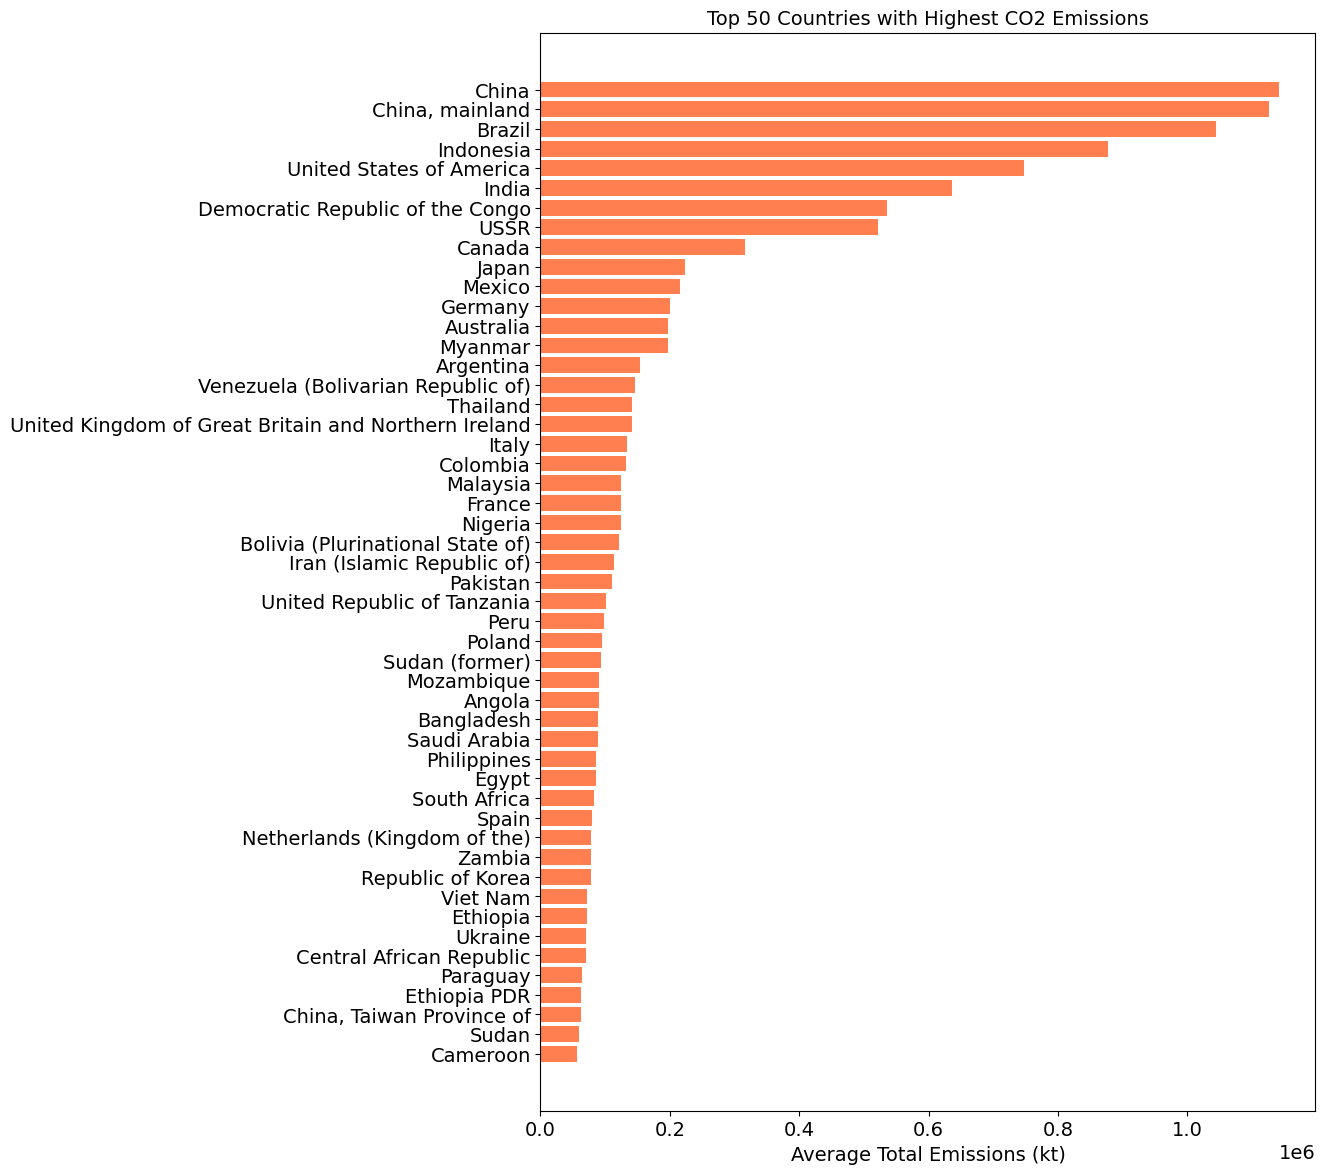

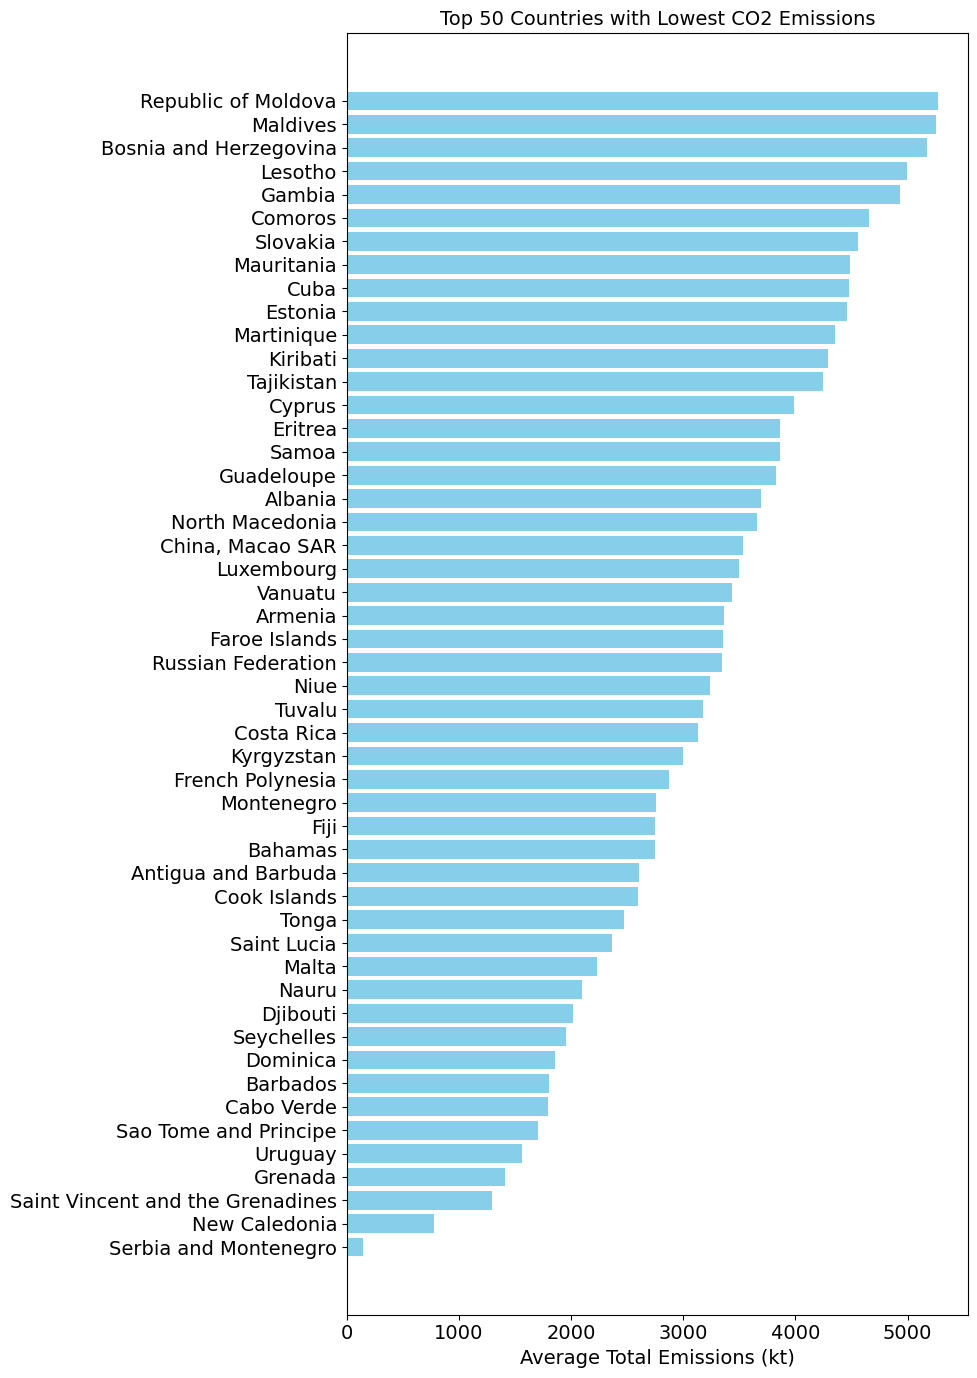

In [106]:
area_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Group by area
average_emission_per_country = data_3.groupby('Area')['total_emission'].mean().reset_index()

# Add original names
average_emission_per_country['Area_name'] = average_emission_per_country['Area'].map(area_mapping)

# Sort on average emission
average_emission_per_country_sorted = average_emission_per_country.sort_values(by='total_emission', ascending=False)

# Plot the top 10 countries with the highest average emission
top_50_countries = average_emission_per_country_sorted.head(50)
plt.figure(figsize=(10, 14))
plt.barh(top_50_countries['Area_name'], top_50_countries['total_emission'], color='#FF7F50')
plt.title('Top 50 Countries with Highest CO2 Emissions', fontsize=14)
plt.xlabel('Average Total Emissions (kt)', fontsize=14)
plt.gca().invert_yaxis()
plt.savefig("Top_50_CO2_Emissions.png")
plt.show()

# Filter - emissions 
average_emission_per_country_sorted_filtered = average_emission_per_country_sorted[
    average_emission_per_country_sorted['total_emission'] >= 0
]

# Bottom 50 countries
bottom_50_countries_filtered = average_emission_per_country_sorted_filtered.tail(50)

# Plot for 50 bottom countries
plt.figure(figsize=(10, 14))
plt.barh(bottom_50_countries_filtered['Area_name'], bottom_50_countries_filtered['total_emission'], color='skyblue')
plt.title('Top 50 Countries with Lowest CO2 Emissions', fontsize=14)
plt.xlabel('Average Total Emissions (kt)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Bottom_50_CO2_Emissions_Filtered.png")  
plt.show()


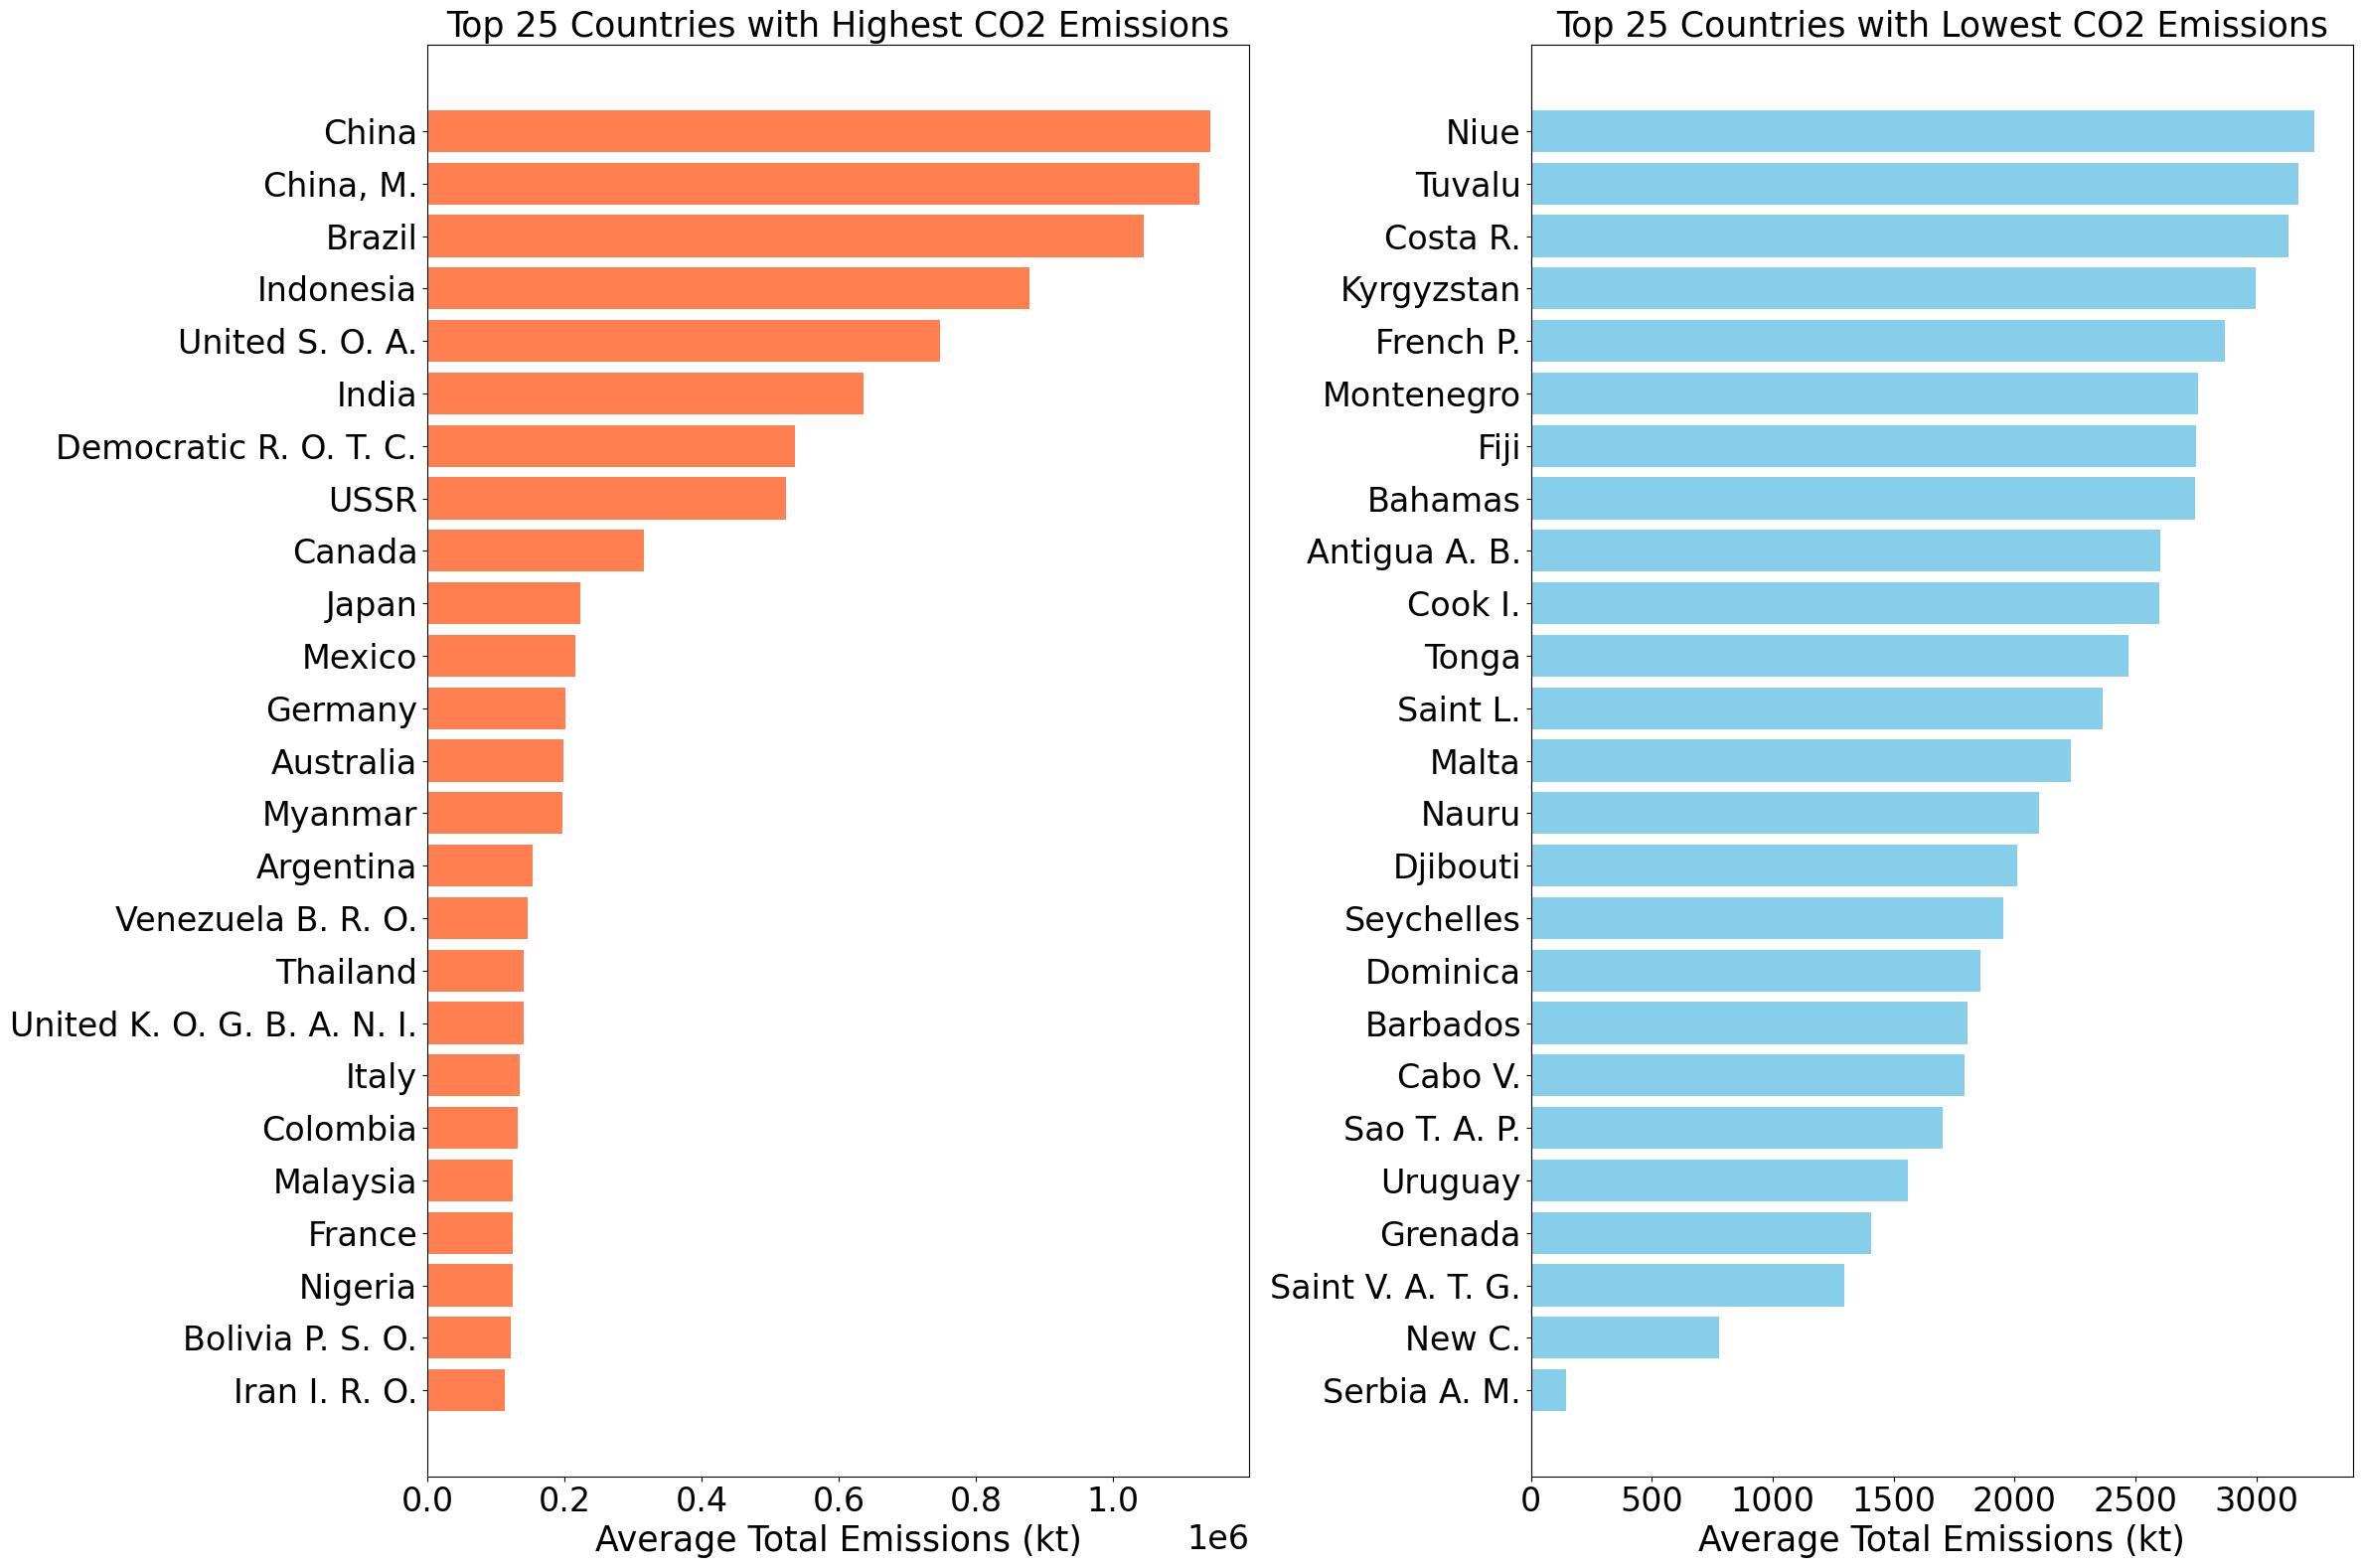

In [182]:
# Generate to smaller words for visualization purposes Overleaf
def create_custom_abbreviation(name):
    words = name.replace('(', '').replace(')', '').split()  
    if len(words) > 1:
        abbreviations = [word[0].upper() + '.' for word in words[1:]]
        return words[0] + ' ' + ' '.join(abbreviations)
    else:
        return name

# List of countries
top_25_countries = top_25_countries.copy()  
bottom_25_countries_filtered = bottom_25_countries_filtered.copy()  

top_25_countries['Area_abbreviation'] = top_25_countries['Area_name'].apply(create_custom_abbreviation)
bottom_25_countries_filtered['Area_abbreviation'] = bottom_25_countries_filtered['Area_name'].apply(create_custom_abbreviation)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 16))

# Plot for the top 25 countries
axes[0].barh(top_25_countries['Area_abbreviation'], top_25_countries['total_emission'], color='#FF7F50')
axes[0].set_title('Top 25 Countries with Highest CO2 Emissions', fontsize=25)
axes[0].set_xlabel('Average Total Emissions (kt)', fontsize=25)
axes[0].invert_yaxis()
axes[0].tick_params(axis='y', labelsize=24)  
axes[0].tick_params(axis='x', labelsize=24) 

# Plot for the bottom 25 countries
axes[1].barh(bottom_25_countries_filtered['Area_abbreviation'], bottom_25_countries_filtered['total_emission'], color='skyblue')
axes[1].set_title('Top 25 Countries with Lowest CO2 Emissions', fontsize=25)
axes[1].set_xlabel('Average Total Emissions (kt)', fontsize=25)
axes[1].invert_yaxis()
axes[1].tick_params(axis='y', labelsize=24)  
axes[1].tick_params(axis='x', labelsize=24)  

# Larger text on the axes
for ax in axes:
    ax.xaxis.get_offset_text().set_fontsize(24)  

# Make the plot
plt.tight_layout()
plt.savefig("Top_and_Bottom_25_CO2_Emissions_Custom_Abbreviations.png")
plt.show()


In [107]:
# Pearson correlation of Area with other features
area_correlations = data_3.corr(method='pearson', numeric_only=True)['Area'].round(2)

# Remove the correlation with Area itselfs
area_correlations_without_self = area_correlations.drop('Area')

# Sort correlations
top_positive_area_correlations = area_correlations_without_self.sort_values(ascending=False).head(10)
top_negative_area_correlations = area_correlations_without_self.sort_values(ascending=True).head(10)

# print results 
print("Top 10 positive correlated features with 'Area':")
print(top_positive_area_correlations)

print("\nTop 10 negative correlated features with 'Area':")
print(top_negative_area_correlations)

Top 10 positive correlated features with 'Area':
Drained organic soils (CO2)    0.06
Food Retail                    0.03
Fires in organic soils         0.01
Forestland                     0.01
Year                           0.00
Food Transport                 0.00
Fertilizers Manufacturing      0.00
Average Temperature °C        -0.01
Food Processing               -0.02
Manure Management             -0.02
Name: Area, dtype: float64

Top 10 negative correlated features with 'Area':
Net Forest conversion             -0.10
Savanna fires                     -0.09
Manure left on Pasture            -0.09
total_emission                    -0.09
Fires in humid tropical forests   -0.08
Rural population                  -0.07
Total Population - Male           -0.07
Agrifood Systems Waste Disposal   -0.07
Total Population - Female         -0.07
Forest fires                      -0.06
Name: Area, dtype: float64


### Scaling

In [183]:
# Scaling with Standardization
data_4 = data_3.copy()

scaler = StandardScaler()
numerical_features = data_4.select_dtypes(include=['int64', 'float64']).columns
data_4[numerical_features] = scaler.fit_transform(data_4[numerical_features])

## 3. Model Development 

### (initial) Feature Selection

In [184]:
x = data_4.drop(columns= ['total_emission'])
y = data_4['total_emission']

### Spliting data in training and test set

In [185]:
# Splitting the data in training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Cross-Validation

In [186]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

### Linear Regression

In [187]:
LR_model = LinearRegression()

mse_list = []
mae_list = []
r2_list = []

# Apply cross-validation in loop
for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    LR_model.fit(x_train, y_train)
    
    # Predict y on the validation fold
    y_pred = LR_model.predict(x_val)
    
    # Evaluate 
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Add results to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Print average scores and standard deviations 
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Average MSE: 0.02508884912930339 Standard deviation MSE: 0.006574244310321466
Average MAE: 0.07663892528104702 Standard deviation MAE: 0.004439673427191349
Average R²: 0.9747784146259996 Standard deviation R²: 0.0033188322015182126


### Random Forest

In [22]:
RF_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)

mse_list = []
mae_list = []
r2_list = []

# Cross-validation loop
for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    RF_model.fit(x_train, y_train)
    
    # Predict y on the validation fold
    y_pred = RF_model.predict(x_val)
   
    # Evaluate 
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Add results to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    
# Print metrics as baseline evaluation, not as final model evaluation
print("Baseline evaluation:")
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Baseline evaluation:
Average MSE: 0.007734349129642788 Standard deviation MSE: 0.005774562781793104
Average MAE: 0.016000993755517667 Standard deviation MAE: 0.0038192941121115483
Average R²: 0.992209990493861 Standard deviation R²: 0.004902864806416332


#### Hyperparameter Tuning RF (remove # for running)

In [23]:
# # RF model without parameters
# RF_model_blanco =  RandomForestRegressor(random_state=0)

# # Hyperparameter tuning with BayesSearchCV 
# search_spaces = {
#     'n_estimators': (50, 150),
#     'max_depth': (5, 50),
#     'min_samples_split': (2, 10),
#     'min_samples_leaf': (1, 10)
# }

# # BayesSearchCV 
# bayes_search = BayesSearchCV(
#     estimator=RF_model_blanco,
#     search_spaces=search_spaces,
#     n_iter=100,  
#     cv=5,  
#     n_jobs=-1,   
#     random_state=0
# )

# # BayesSearchCV fit
# tuned_model = bayes_search.fit(x, y)

# best_params = bayes_search.best_params_

# # Print the best parameters
# print("The best Hyperparameters of RF:", best_params)

C:\Users\kimos\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [34, 1, 2, 50] before, using random point [13, 9, 8, 117]
  warnings.warn(
C:\Users\kimos\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 2, 50] before, using random point [39, 8, 8, 144]
  warnings.warn(


The best Hyperparameters of RF: OrderedDict([('max_depth', 50), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 51)])


#### RF Model with Hyperparmeter Tuning

In [30]:
# Hyperparameters for RF_tuned (Output previous cell with randomstate = 0)
best_params = {
    "n_estimators": 51,
    "max_depth": 50,
    "min_samples_split": 3,
    "min_samples_leaf": 1
}

# RF model
RF_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=0
)

# Cross-validation loop
mse_list_tuned = []
mae_list_tuned = []
r2_list_tuned = []

for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    #Train the model
    RF_tuned.fit(x_train, y_train)
    
    # Predict y on the validation fold
    y_pred = RF_tuned.predict(x_val)
   
    # Evaluate
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Add results to the lists
    mse_list_tuned.append(mse)
    mae_list_tuned.append(mae)
    r2_list_tuned.append(r2)

# Print evaluation
print("\nModel with Hyperparameter Tuning:")
print("Gemiddelde MSE:", np.mean(mse_list_tuned), "Standaarddeviatie MSE:", np.std(mse_list_tuned))
print("Gemiddelde MAE:", np.mean(mae_list_tuned), "Standaarddeviatie MAE:", np.std(mae_list_tuned))
print("Gemiddelde R²:", np.mean(r2_list_tuned), "Standaarddeviatie R²:", np.std(r2_list_tuned))


Model with Hyperparameter Tuning:
Gemiddelde MSE: 0.007945794290692596 Standaarddeviatie MSE: 0.005842700374694067
Gemiddelde MAE: 0.016480265919180948 Standaarddeviatie MAE: 0.004083653866981971
Gemiddelde R²: 0.9919715117592137 Standaarddeviatie R²: 0.004978815894260815


### Gradient Boosting Machines

In [25]:
GB_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

mse_list = []
mae_list = []
r2_list = []

# Cross-validation loop
for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    GB_model.fit(x_train, y_train)
    
    # Predict y on the validation fold
    y_pred = GB_model.predict(x_val)
   
    # Evaluate 
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Add results to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Print metrics as insights, not as final model evaluation
print("Baseline evaluation:")
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Baseline evaluation:
Average MSE: 0.00956656145369439 Standard deviation MSE: 0.00491722946058935
Average MAE: 0.037966512442981756 Standard deviation MAE: 0.004580971270791598
Average R²: 0.9903033350273651 Standard deviation R²: 0.00454619577849491


#### Hyperparameter Tuning GBM (Remove # for running)

In [26]:
# # Baseline Gradient Boosting Regressor
# GB_model_blanco = GradientBoostingRegressor(random_state=0, n_iter_no_change=10,
#     validation_fraction=0.1)

# # Hyperparameter tuning with BayesSearchCV 
# search_spaces = {
#     'n_estimators': (50, 500),
#     'learning_rate': (0.01, 0.2, 'log-uniform'),
#     'max_depth': (3, 15),
#     'min_samples_split': (2, 25),
#     'min_samples_leaf': (1, 40)
# }

# # BayesSearchCV 
# bayes_search = BayesSearchCV(
#     estimator=GB_model_blanco,
#     search_spaces=search_spaces,
#     n_iter=80,  
#     cv=5,  
#     n_jobs=-1,   
#     random_state=0
# )

# # Fit BayesSearchCV to the data
# tuned_modelGBM = bayes_search.fit(x, y)

# best_paramsGBM = tuned_modelGBM.best_params_

# # Print the best parameters
# print("The best Hyperparameters of GBM:", best_paramsGBM)

The best Hyperparameters of GBM: OrderedDict([('learning_rate', 0.08107087827070233), ('max_depth', 11), ('min_samples_leaf', 40), ('min_samples_split', 25), ('n_estimators', 488)])


#### GBM model with Hyperparameter Tuning

In [33]:
# Hyperparameters for GBM_tuned (Output previous cell with randomstate = 0)
best_paramsGBM = {
    "learning_rate": 0.08107087827070233,
    "max_depth": 11,
    "min_samples_leaf": 40,
    "min_samples_split": 25,
    "n_estimators": 488
}

# Train GBM with the hyperparameters
GBM_tuned = GradientBoostingRegressor(
    n_estimators=best_paramsGBM['n_estimators'],
    max_depth=best_paramsGBM['max_depth'],
    learning_rate=best_paramsGBM['learning_rate'],
    min_samples_split=best_paramsGBM['min_samples_split'],
    min_samples_leaf=best_paramsGBM['min_samples_leaf'],
    random_state=0
)

# Cross-validation evaluation
mse_list_gbm, mae_list_gbm, r2_list_gbm = [], [], []

for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    GBM_tuned.fit(x_train, y_train)
    y_pred = GBM_tuned.predict(x_val)
    
    mse_list_gbm.append(mean_squared_error(y_val, y_pred))
    mae_list_gbm.append(mean_absolute_error(y_val, y_pred))
    r2_list_gbm.append(r2_score(y_val, y_pred))

# Print results
print("\nGBM Model with Hyperparameter Tuning:")
print("Average MSE:", np.mean(mse_list_gbm), "Standaarddeviatie MSE:", np.std(mse_list_gbm))
print("Average MAE:", np.mean(mae_list_gbm), "Standaarddeviatie MAE:", np.std(mae_list_gbm))
print("Average R²:", np.mean(r2_list_gbm), "Standaarddeviatie R²:", np.std(r2_list_gbm))


GBM Model with Hyperparameter Tuning:
Average MSE: 0.006388724712787614 Standaarddeviatie MSE: 0.003434425997411085
Average MAE: 0.01993301555410649 Standaarddeviatie MAE: 0.0035302568629725054
Average R²: 0.9933548612777662 Standaarddeviatie R²: 0.00389305365356811


### FNN

In [42]:
mse_list = []
mae_list = []
r2_list = []

FNN_model = MLPRegressor(hidden_layer_sizes=(1000,), activation='relu', solver='adam', 
                         max_iter=1000, random_state=0)

# Cross-validation loop
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Training the model
    FNN_model.fit(x_train, y_train)
    
    # Made predictions
    y_pred = FNN_model.predict(x_test)
   
    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Add results to the list
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Print the scores
print("Baseline evaluation:")
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Baseline evaluation:
Average MSE: 0.018475254739360264 Standard deviation MSE: 0.009166162530285942
Average MAE: 0.08416718956396049 Standard deviation MAE: 0.036270826185418874
Average R²: 0.980943900621214 Standard deviation R²: 0.009267644595406488


#### Hyperparameter Tuning FNN (remove # for running)

In [43]:
# print(type(x), type(y))
# print(x.shape, y.shape)

# # Define the baseline MLPRegressor model
# FNN_model_blanco = MLPRegressor(max_iter=2000, random_state=0, early_stopping=True)

# # Define the parameter search space
# search_spaces = {
#     'hidden_layer_sizes': Categorical([50, 100]),
#     'activation': Categorical(['relu', 'tanh']),
#     'solver': Categorical(['adam', 'lbfgs']),
#     'alpha': Real(1e-4, 5e-4, prior='log-uniform'),
#     'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
# }

# # BayesSearchCV for hyperparameter tuning
# bayes_search = BayesSearchCV(
#     estimator=FNN_model_blanco,
#     search_spaces=search_spaces,
#     n_iter=100,
#     cv=5,
#     n_jobs=-1,
#     random_state=0,
#     verbose=3  # Enable logging to trace the process
# )

# # Perform hyperparameter tuning with a callback
# tuned_modelFNN = bayes_search.fit(x, y, callback=[DeltaYStopper(1e-6)])

# # Get the best parameters found
# best_paramsFNN = tuned_modelFNN.best_params_

# # Print the best parameters
# print("The best Hyperparameters:", best_paramsFNN)


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(6965, 30) (6965,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for ea

#### FNN with Hyperparameter Tuning

In [32]:
# Hyperparameters for GBM_tuned (Output previous cell with randomstate = 0)
best_paramsFNN = {
    "hidden_layer_sizes": 100,
    "activation": "relu",
    "solver": "adam",
    "alpha": 0.0001,
    "learning_rate_init": 0.0017735704525922659
}

    
# Train FNN with hyperparameters
FNN_tuned = MLPRegressor(
    hidden_layer_sizes=best_paramsFNN['hidden_layer_sizes'],
    activation=best_paramsFNN['activation'],
    solver=best_paramsFNN['solver'],
    alpha=best_paramsFNN['alpha'],  
    learning_rate= 'adaptive',  
    learning_rate_init=best_paramsFNN['learning_rate_init'],  
    max_iter=5000, # was 2000
    early_stopping=True,
    random_state=0
)

# Cross-validation evaluation
mse_list_fnn, mae_list_fnn, r2_list_fnn = [], [], []

for train_index, val_index in kf.split(x):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    FNN_tuned.fit(x_train, y_train)
    y_pred = FNN_tuned.predict(x_val)
    
    mse_list_fnn.append(mean_squared_error(y_val, y_pred))
    mae_list_fnn.append(mean_absolute_error(y_val, y_pred))
    r2_list_fnn.append(r2_score(y_val, y_pred))

# Print results
print("\nFNN Model with Hyperparameter Tuning:")
print("Mean MSE:", np.mean(mse_list_fnn), "Standaarddeviatie MSE:", np.std(mse_list_fnn))
print("Mean MAE:", np.mean(mae_list_fnn), "Standaarddeviatie MAE:", np.std(mae_list_fnn))
print("Mean R²:", np.mean(r2_list_fnn), "Standaarddeviatie R²:", np.std(r2_list_fnn))


FNN Model with Hyperparameter Tuning:
Mean MSE: 0.010695542343551375 Standaarddeviatie MSE: 0.00604161820818583
Mean MAE: 0.04275804088320656 Standaarddeviatie MAE: 0.005922404043766265
Mean R²: 0.9896174217023999 Standaarddeviatie R²: 0.004036670421726908


## Feature Importance Analysis

In [188]:
# Add Gaussian perturbation to features
def perturb_features(X, features_to_perturb, std_dev=0.1):
    np.random.seed(0)
    X_perturbed = X.copy()
    for feature in features_to_perturb:
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame.")
        X_perturbed[feature] += np.random.normal(0, std_dev, size=X.shape[0])
    return X_perturbed


def compute_pgi2(model, X, y, feature_subset, std_dev=0.1):
    """
    Compute the PGI² metric for a given feature subset.
    Ensures compatibility with models expecting feature names.
    """
    if not isinstance(X, pd.DataFrame):
        raise ValueError(f"Input X must be a pandas DataFrame, but got {type(X)} instead.")

    # Original predictions
    original_preds = model.predict(X)

    # Perturb features and maintain DataFrame structure
    perturbed_X = perturb_features(X, feature_subset, std_dev)

    if not perturbed_X.columns.equals(X.columns):
        raise ValueError("Column names of perturbed_X do not match original X.")

    # Predictions on perturbed data
    perturbed_preds = model.predict(perturbed_X)

    # Compute and return PGI²
    return np.mean((perturbed_preds - original_preds) ** 2)


# Compute average PGI2 for a feature ranking
def compute_average_pgi2(model, X, y, feature_ranking, std_dev=0.1):
    """
    Compute the average PGI² metric for a given feature ranking.
    """
    d = len(feature_ranking)  # Total number of features
    total_pgi2 = 0.0

    for k in range(1, d + 1):  # Iterate over subset sizes
        subset = feature_ranking[:k]
        pgi2 = compute_pgi2(model, X, y, subset, std_dev)
        total_pgi2 += pgi2

    average_pgi2 = total_pgi2 / d
    return average_pgi2


# Rank features using PGI2 with greedy selection
def rank_features_pgi2(model, X, y, std_dev=0.1):
    """
    Rank features based on PGI² using a greedy selection algorithm.
    """
    feature_indices = list(range(X.shape[1]))
    feature_names = X.columns.tolist()  # Map indices to column names
    ranked_features = []
    remaining_features = set(feature_indices)

    while remaining_features:
        best_feature = None
        best_pgi2 = -np.inf

        for feature in remaining_features:
            current_subset = ranked_features + [feature_names[feature]]  # Map index to name
            pgi2 = compute_pgi2(model, X, y, current_subset, std_dev)
            if pgi2 > best_pgi2:
                best_pgi2 = pgi2
                best_feature = feature

        ranked_features.append(feature_names[best_feature])  # Append the feature name
        remaining_features.remove(best_feature)

    return ranked_features

print("Feature Importance Analysis with PGI2:")

# Ensure X is a DataFrame
if not isinstance(x_train, pd.DataFrame):
    raise ValueError("Input x_train must be a pandas DataFrame with valid feature names.")

# Random Forest Feature Importance
rf_ranked_features = rank_features_pgi2(RF_tuned, x_train, y_train)
print(f"Random Forest ranked features: {rf_ranked_features}")

# Compute average PGI² for RF model
rf_average_pgi2 = compute_average_pgi2(RF_tuned, x_train, y_train, rf_ranked_features)
print(f"Random Forest Average PGI²: {rf_average_pgi2}")

# Gradient Boosting Feature Importance
gb_ranked_features = rank_features_pgi2(GBM_tuned, x_train, y_train)
print(f"Gradient Boosting ranked features: {gb_ranked_features}")

# Compute average PGI² for GB model
gb_average_pgi2 = compute_average_pgi2(GBM_tuned, x_train, y_train, gb_ranked_features)
print(f"Gradient Boosting Average PGI²: {gb_average_pgi2}")


Feature Importance Analysis with PGI2:
Random Forest ranked features: ['Rural population', 'Agrifood Systems Waste Disposal', 'On-farm Electricity Use', 'IPPU', 'Net Forest conversion', 'Urban population', 'Rice Cultivation', 'Total Population - Male', 'Food Processing', 'Food Household Consumption', 'Savanna fires', 'Manure Management', 'Fires in humid tropical forests', 'Total Population - Female', 'Drained organic soils (CO2)', 'Manure applied to Soils', 'Food Transport', 'Manure left on Pasture', 'Fertilizers Manufacturing', 'Forestland', 'Forest fires', 'Food Packaging', 'Crop Residues', 'Fires in organic soils', 'Year', 'On-farm energy use', 'Food Retail', 'Pesticides Manufacturing', 'Average Temperature °C', 'Area']
Random Forest Average PGI²: 0.023518530134519676
Gradient Boosting ranked features: ['Net Forest conversion', 'Agrifood Systems Waste Disposal', 'Forestland', 'Urban population', 'IPPU', 'Total Population - Male', 'Savanna fires', 'Total Population - Female', 'Fires 

### Ploting the feature importance

#### PGI² scores

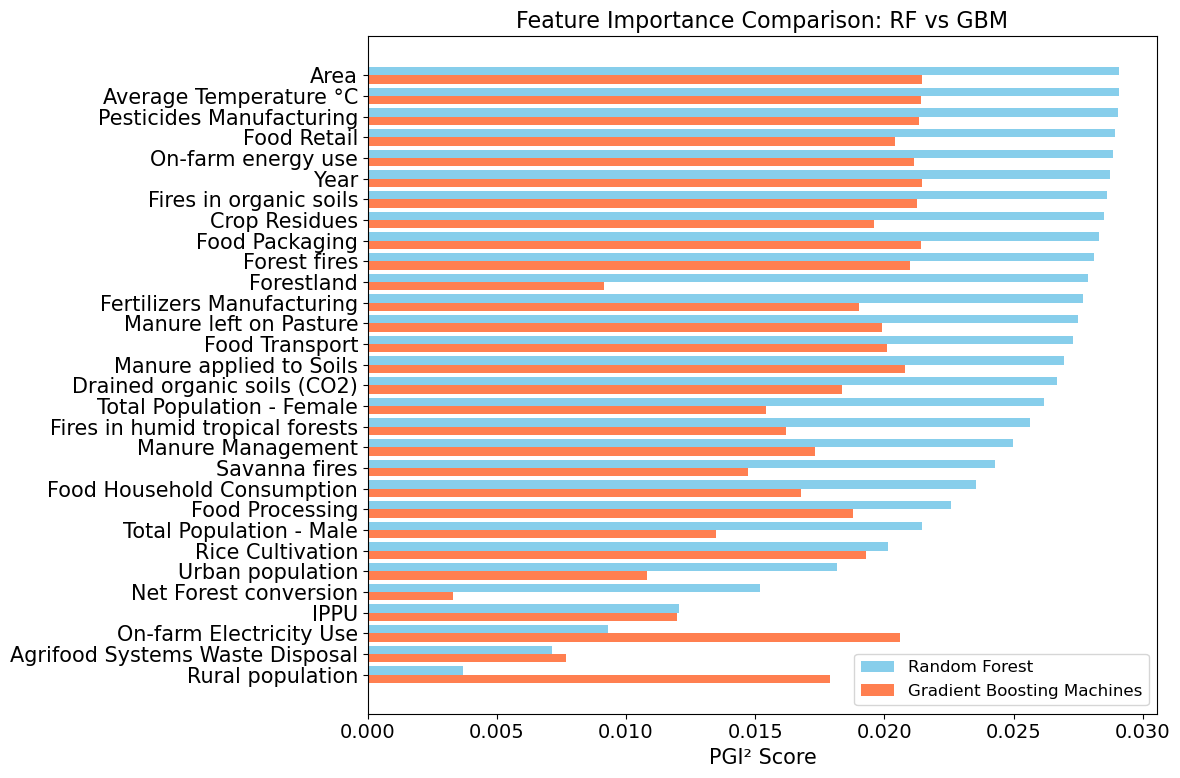

In [189]:
# Rank features and calculate their PGI² scores
def rank_features_with_scores(model, X, y, std_dev=0.1):
    """
    Rank features based on PGI² and return their scores.
    """
    feature_indices = list(range(X.shape[1]))
    feature_names = X.columns.tolist()  # Map indices to column names
    scores = {name: 0 for name in feature_names}
    ranked_features = []
    remaining_features = set(feature_indices)

    while remaining_features:
        best_feature = None
        best_pgi2 = -np.inf

        for feature in remaining_features:
            current_subset = ranked_features + [feature_names[feature]]  # Map index to name
            pgi2 = compute_pgi2(model, X, y, current_subset, std_dev)
            if pgi2 > best_pgi2:
                best_pgi2 = pgi2
                best_feature = feature

        ranked_features.append(feature_names[best_feature])  # Append the feature name
        scores[feature_names[best_feature]] = best_pgi2  # Save the PGI² score
        remaining_features.remove(best_feature)

    return ranked_features, scores

# Combine scores from both models for comparison
def combine_model_scores(rf_scores, gb_scores):
    """
    Combine feature scores from RF and GBM into a single DataFrame.
    """
    combined_scores = pd.DataFrame({
        "Feature": list(rf_scores.keys()),
        "RF_PGI² Score": list(rf_scores.values()),
        "GBM_PGI² Score": list(gb_scores.values())
    })
    combined_scores = combined_scores.sort_values(by="RF_PGI² Score", ascending=False)
    return combined_scores

# Rank features and calculate their PGI² scores for both models
rf_ranked_features, rf_scores = rank_features_with_scores(RF_tuned, x_train, y_train)
gb_ranked_features, gbm_scores = rank_features_with_scores(GBM_tuned, x_train, y_train)

# Combine scores for both models
combined_scores = combine_model_scores(rf_scores, gbm_scores)

# Adjust text size for the plot
plt.rcParams.update({'font.size': 14})  # Set global font size for the plot

# Plot combined feature importances
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4  # Width of the bars
indices = np.arange(len(combined_scores))  # Bar positions

# Plot RF scores
ax.barh(indices - width/2, combined_scores["RF_PGI² Score"], height=width, label="Random Forest", color='skyblue')

# Plot GBM scores
ax.barh(indices + width/2, combined_scores["GBM_PGI² Score"], height=width, label="Gradient Boosting Machines", color='#FF7F50')

# Add labels and legend with larger font sizes
ax.set_yticks(indices)
ax.set_yticklabels(combined_scores["Feature"], fontsize=15)  
ax.set_xlabel("PGI² Score", fontsize=15) 
ax.set_title("Feature Importance Comparison: RF vs GBM", fontsize=16)  
ax.legend(fontsize=12) 

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('feature_comparisonRFvsGBM.png')  
plt.show()

#### Highest rankings

In [190]:
# Combine feature rankings from both models
def combine_model_rankings_clean(rf_scores, gb_scores):
    """
    Combine feature rankings from RF and GBM into a single DataFrame with clean structure.
    """
    # Create a DataFrame with rankings only
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),  # Feature names
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),  # RF ranking
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)  # GBM ranking
    }).set_index("Feature")  # Set Feature as index to avoid duplication
    
    # Sort by RF rank as default
    combined_rankings = combined_rankings.sort_values(by="RF_Rank")
    return combined_rankings

# Combine rankings for both models
combined_rankings_clean = combine_model_rankings_clean(rf_scores, gbm_scores)

# Display the DataFrame
print(combined_rankings_clean)



                                 RF_Rank  GBM_Rank
Feature                                           
Area                                   1         1
Average Temperature °C                 2         3
Pesticides Manufacturing               3         5
Food Retail                            4        11
On-farm energy use                     5         7
Year                                   6         2
Fires in organic soils                 7         6
Crop Residues                          8        14
Food Packaging                         9         4
Forest fires                          10         8
Forestland                            11        28
Fertilizers Manufacturing             12        16
Manure left on Pasture                13        13
Food Transport                        14        12
Manure applied to Soils               15         9
Drained organic soils (CO2)           16        18
Total Population - Female             17        23
Fires in humid tropical forests

In [ ]:
# Calculate the top 10 features with the largest ranking differences
def largest_ranking_differences(rf_scores, gb_scores):
    """
    Identify the top 10 features with the largest differences in rankings between RF and GBM.
    """
    # Create a DataFrame with rankings and calculate differences
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),  # Feature names
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),  # RF ranking
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)  # GBM ranking
    })
    combined_rankings["Rank_Difference"] = (combined_rankings["RF_Rank"] - combined_rankings["GBM_Rank"]).abs()
    
    # Sort by the largest differences and select the top 10
    largest_differences = combined_rankings.sort_values(by="Rank_Difference", ascending=False).head(10)
    return largest_differences

# Get the top 10 features with the largest ranking differences
top_10_differences = largest_ranking_differences(rf_scores, gbm_scores)

# Display the DataFrame
print(top_10_differences)


#### Lowest rankings

In [ ]:
# Identify the lowest ranked features
def lowest_ranking_features(rf_scores, gb_scores, top_n=10):
    """
    Identify the features with the lowest combined rankings from RF and GBM.
    """
    # Create a DataFrame with rankings
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),  # Feature names
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),  # RF ranking
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)  # GBM ranking
    })
    
    # Calculate a combined rank by summing RF and GBM ranks
    combined_rankings["Combined_Rank"] = combined_rankings["RF_Rank"] + combined_rankings["GBM_Rank"]
    
    # Sort by combined rank to get the lowest overall priority features
    lowest_ranked = combined_rankings.sort_values(by="Combined_Rank", ascending=False).head(top_n)
    return lowest_ranked

# Get the top 10 lowest ranked features
lowest_10_ranked_features = lowest_ranking_features(rf_scores, gbm_scores)

# Display the DataFrame
print(lowest_10_ranked_features)


In [ ]:
# Sort worst-ranked features on top
def sort_worst_rankings(rf_scores, gb_scores):
    """
    Combine feature rankings and sort by the lowest priority features.
    """
    combined_rankings = pd.DataFrame({
        "Feature": list(rf_scores.keys()),  # Feature names
        "RF_Rank": pd.Series(rf_scores).rank(ascending=False).astype(int),  # RF ranking
        "GBM_Rank": pd.Series(gb_scores).rank(ascending=False).astype(int)  # GBM ranking
    })

    # Sort by RF_Rank and GBM_Rank in descending order (worst ranks first)
    combined_rankings["Max_Rank"] = combined_rankings[["RF_Rank", "GBM_Rank"]].max(axis=1)
    combined_rankings = combined_rankings.sort_values(by="Max_Rank", ascending=False)

    return combined_rankings.drop(columns=["Max_Rank"])

# Get the worst-ranked features sorted
worst_ranked_features = sort_worst_rankings(rf_scores, gbm_scores)

# Display the DataFrame
print(worst_ranked_features)

#### SHAP

In [ ]:
# 1. SHAP RF
explainer_rf = shap.TreeExplainer(RF_tuned)
shap_values_rf = explainer_rf.shap_values(x_train)

# 2. SHAP GB
explainer_gbm = shap.TreeExplainer(GBM_tuned)
shap_values_gbm = explainer_gbm.shap_values(x_train)

shap_importance_rf = np.abs(shap_values_rf).mean(axis=0)
shap_importance_gbm = np.abs(shap_values_gbm).mean(axis=0)

# Combine SHAP values for plot
shap_scores = pd.DataFrame({
    "Feature": x_train.columns,
    "RF_SHAP Score": shap_importance_rf,
    "GBM_SHAP Score": shap_importance_gbm
}).sort_values(by="RF_SHAP Score", ascending=False)

# Plot SHAP values
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.35 
indices = np.arange(len(shap_scores))  

# BRF SHAP-scores
ax.barh(indices - width/2, shap_scores["RF_SHAP Score"], height=width, label="Random Forest", color='skyblue')

# GBM SHAP-scores
ax.barh(indices + width/2, shap_scores["GBM_SHAP Score"], height=width, label="Gradient Boosting", color='#FF7F50')

# Labels
ax.set_yticks(indices)
ax.set_yticklabels(shap_scores["Feature"])
ax.set_xlabel("SHAP Score")
ax.set_title("Feature Importance Based on SHAP: RF vs GBM")
ax.legend()

# Important Features as first:
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('shap_comparison_RF_GBM.png')
plt.show()

# Beeswarm plot Random Forest
shap.summary_plot(shap_values_rf, x_train)

# Beeswarm plot Gradient Boosting
shap.summary_plot(shap_values_gbm, x_train)


In [ ]:
# COMP?

#### Multicollineariteit PCA analysis

In [56]:
# PCA model
# features without the target variable:
features_2 = data_4.drop(columns=['total_emission'])

pca = PCA()
pca.fit(features_2)

# Variance per component 
explained_variance = pca.explained_variance_ratio_
print("Explained Variance per Component:", explained_variance)


Explained Variance per Component: [9.93741814e-01 3.61760715e-03 5.85902790e-04 3.88009741e-04
 3.20090244e-04 2.85438259e-04 2.01166400e-04 1.56221155e-04
 1.29737035e-04 1.08437448e-04 9.54845678e-05 7.38037818e-05
 5.72180091e-05 4.24197147e-05 3.82926098e-05 3.07319641e-05
 2.20947953e-05 1.97375627e-05 1.64350102e-05 1.58759615e-05
 1.18594021e-05 9.89029452e-06 8.98772328e-06 7.36419900e-06
 6.76196637e-06 3.94754529e-06 2.51629254e-06 1.84544900e-06
 2.96458607e-07 1.23106264e-08]


Top 5 Variables for PC1:
Area                               0.999991
Net Forest conversion              0.001530
Savanna fires                      0.001364
Manure left on Pasture             0.001361
Fires in humid tropical forests    0.001129
Name: PC1, dtype: float64

Top 5 Variables for PC2:
Urban population             0.236619
Manure applied to Soils      0.236350
Manure Management            0.235626
Crop Residues                0.235308
Total Population - Female    0.228896
Name: PC2, dtype: float64

Top 5 Variables for PC3:
Forest fires                       0.545013
Fires in humid tropical forests    0.541143
Net Forest conversion              0.405201
Savanna fires                      0.377741
Fires in organic soils             0.162639
Name: PC3, dtype: float64

Top 5 Variables for PC4:
Drained organic soils (CO2)    0.403042
Average Temperature °C         0.390251
Year                           0.317268
Rural population               0.296757
Rice Cultivation             

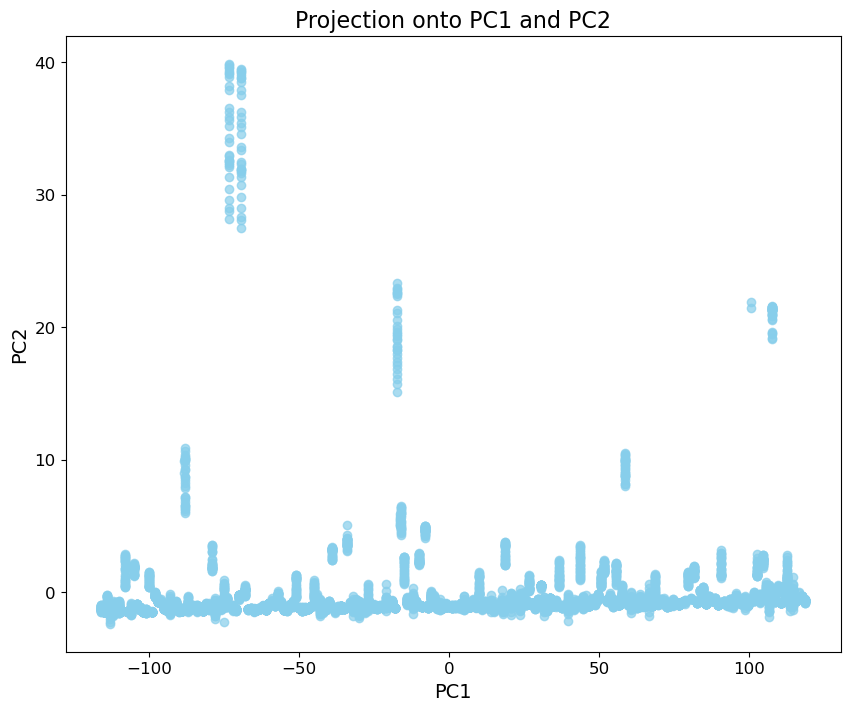

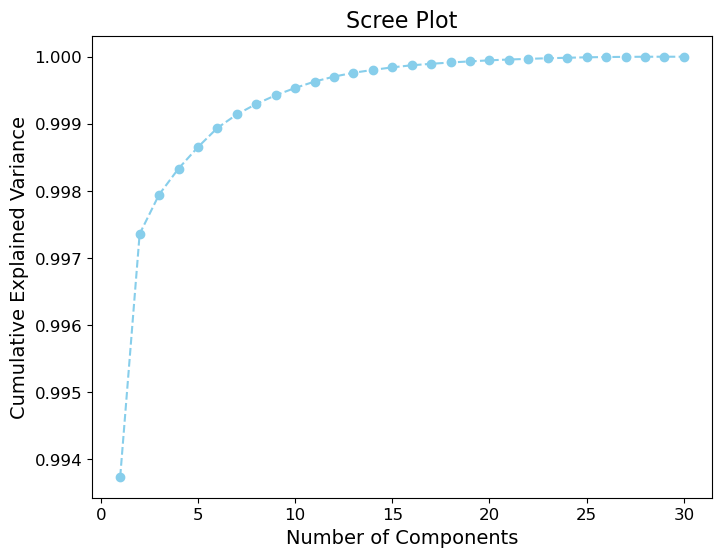

Cumulative explained variance for PC1 and PC2: 1.00


In [223]:
# Extract the loadings (original variables' contributions to each component)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features_2.columns  
)

for pc in loadings.columns:
    # Select top 5 variables
    top_loadings = loadings[pc].abs().nlargest(5)
    print(f"Top 5 Variables for {pc}:\n{top_loadings}\n")


# Project data onto the principal components
projected_data = pd.DataFrame(pca.transform(features_2), columns=[f'PC{i+1}' for i in range(features_2.shape[1])])

# Scatterplot of the first two principal components with skyblue color
plt.figure(figsize=(10, 8))
plt.scatter(projected_data['PC1'], projected_data['PC2'], alpha=0.7, color='skyblue')
plt.xlabel("PC1", fontsize=14)  
plt.ylabel("PC2", fontsize=14)  
plt.title("Projection onto PC1 and PC2", fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.savefig("scatterplot_pc1_pc2_larger_text.png", dpi=300)  
plt.show()

# Scree plot to show cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), np.cumsum(explained_variance), marker='o', linestyle='--', color='skyblue')
plt.xlabel("Number of Components", fontsize=14)  
plt.ylabel("Cumulative Explained Variance", fontsize=14) 
plt.title("Scree Plot", fontsize=16) 
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.savefig("screeplot_cumulative_variance_larger_text.png", dpi=300)  
plt.show()

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Print cumulative variance for PC1 and PC2
pc1_pc2_variance = cumulative_variance[1]  # Cumulative variance up to PC2
print(f"Cumulative explained variance for PC1 and PC2: {pc1_pc2_variance:.2f}")

## Feature selection 2

In [62]:
# Selected features with RF PGI² > 0.015
selected_features = [feature for feature, score in rf_scores.items() if score > 0.015]

# Copy of x with the selected features only
x_2 = x[selected_features]

# Print the new features set:
print("Selected Features:", selected_features)

print(len(selected_features))

Selected Features: ['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues', 'Rice Cultivation', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport', 'Forestland', 'Net Forest conversion', 'Food Household Consumption', 'Food Retail', 'Food Packaging', 'Food Processing', 'Fertilizers Manufacturing', 'Manure applied to Soils', 'Manure left on Pasture', 'Manure Management', 'Fires in organic soils', 'Fires in humid tropical forests', 'On-farm energy use', 'Urban population', 'Total Population - Male', 'Total Population - Female', 'Average Temperature °C']
26


### LR Performance after Feature Selection

In [63]:
LR_model_tuned2 = LinearRegression()

mse_list = []
mae_list = []
r2_list = []

# Apply cross-validation in loop
for train_index, val_index in kf.split(x_2):  
    x_train, x_val = x_2.iloc[train_index], x_2.iloc[val_index]  
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    LR_model.fit(x_train, y_train)
    
    # Predict y on the validation fold
    y_pred = LR_model.predict(x_val)
    
    # Evaluate 
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Add results to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Print average scores and standard deviations 
print("Average MSE:", np.mean(mse_list), "Standard deviation MSE:", np.std(mse_list))
print("Average MAE:", np.mean(mae_list), "Standard deviation MAE:", np.std(mae_list))
print("Average R²:", np.mean(r2_list), "Standard deviation R²:", np.std(r2_list))

Average MSE: 0.029526481549572846 Standard deviation MSE: 0.007271226146927438
Average MAE: 0.07300928696897663 Standard deviation MAE: 0.004892600780183593
Average R²: 0.9703137830645536 Standard deviation R²: 0.0028285596073054677


### RF Performance after Feature Selection

In [64]:
# Create a new model RF_tuned2
RF_tuned2 = RandomForestRegressor(**RF_tuned.get_params())  # Copy the same hyperparameters

mse_list_rf_fs = []
mae_list_rf_fs = []
r2_list_rf_fs = []

for train_index, val_index in kf.split(x_2):  
    x_train_fs, x_val_fs = x_2.iloc[train_index], x_2.iloc[val_index]
    y_train_fs, y_val_fs = y.iloc[train_index], y.iloc[val_index]

    # Train the new RF_tuned2 model on the reduced feature set
    RF_tuned2.fit(x_train_fs, y_train_fs)

    # Predict on the validation set
    y_pred_fs = RF_tuned2.predict(x_val_fs)

    # Evaluate the model
    mse = mean_squared_error(y_val_fs, y_pred_fs)
    mae = mean_absolute_error(y_val_fs, y_pred_fs)
    r2 = r2_score(y_val_fs, y_pred_fs)

    # Store the results
    mse_list_rf_fs.append(mse)
    mae_list_rf_fs.append(mae)
    r2_list_rf_fs.append(r2)

# Print evaluation results
print("\nRF Model after Feature Selection (RF_tuned2):")
print("Average MSE:", np.mean(mse_list_rf_fs), "Standard Deviation MSE:", np.std(mse_list_rf_fs))
print("Average MAE:", np.mean(mae_list_rf_fs), "Standard Deviation MAE:", np.std(mae_list_rf_fs))
print("Average R²:", np.mean(r2_list_rf_fs), "Standard Deviation R²:", np.std(r2_list_rf_fs))



RF Model after Feature Selection (RF_tuned2):
Average MSE: 0.00873824207904804 Standard Deviation MSE: 0.005953235721401728
Average MAE: 0.017087450161670004 Standard Deviation MAE: 0.003334481410873863
Average R²: 0.9911804262913385 Standard Deviation R²: 0.005503638523502842


### GBM Performance after Feature Selection

In [65]:
# Create a new GBM model: GBM_tuned2
GBM_tuned2 = GradientBoostingRegressor(**GBM_tuned.get_params())  # Copy the same hyperparameters

# Initialize lists for storing results
mse_list_gbm_fs, mae_list_gbm_fs, r2_list_gbm_fs = [], [], []

for train_index, val_index in kf.split(x_2):  
    x_train_fs, x_val_fs = x_2.iloc[train_index], x_2.iloc[val_index]
    y_train_fs, y_val_fs = y.iloc[train_index], y.iloc[val_index]

    # Train the new GBM model on the reduced feature set
    GBM_tuned2.fit(x_train_fs, y_train_fs)

    # Predict on the validation set
    y_pred_fs = GBM_tuned2.predict(x_val_fs)

    # Evaluate the model
    mse_list_gbm_fs.append(mean_squared_error(y_val_fs, y_pred_fs))
    mae_list_gbm_fs.append(mean_absolute_error(y_val_fs, y_pred_fs))
    r2_list_gbm_fs.append(r2_score(y_val_fs, y_pred_fs))

# Print results after feature selection
print("\nGBM Model after Feature Selection (GBM_tuned2):")
print("Average MSE:", np.mean(mse_list_gbm_fs), "Standard Deviation MSE:", np.std(mse_list_gbm_fs))
print("Average MAE:", np.mean(mae_list_gbm_fs), "Standard Deviation MAE:", np.std(mae_list_gbm_fs))
print("Average R²:", np.mean(r2_list_gbm_fs), "Standard Deviation R²:", np.std(r2_list_gbm_fs))



GBM Model after Feature Selection (GBM_tuned2):
Average MSE: 0.007195984042382375 Standard Deviation MSE: 0.005262278490426925
Average MAE: 0.019804035305239203 Standard Deviation MAE: 0.0037981572979309823
Average R²: 0.9928125200965411 Standard Deviation R²: 0.005212353262093586


### FNN Performance after Feature Selection

In [66]:
# Copy the FNN model
FNN_tuned2 = MLPRegressor(**FNN_tuned.get_params())

# Cross-validation loop for the copied model
mse_list_fnn2, mae_list_fnn2, r2_list_fnn2 = [], [], []

for train_index, val_index in kf.split(x_2):  
    x_train, x_val = x_2.iloc[train_index], x_2.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the copied FNN model
    FNN_tuned2.fit(x_train, y_train)
    y_pred = FNN_tuned2.predict(x_val)
    
    # Evaluate the copied model
    mse_list_fnn2.append(mean_squared_error(y_val, y_pred))
    mae_list_fnn2.append(mean_absolute_error(y_val, y_pred))
    r2_list_fnn2.append(r2_score(y_val, y_pred))

# Print evaluation results for FNN_tuned2
print("\nFNN_tuned2 Evaluation:")
print("Mean MSE:", np.mean(mse_list_fnn2), "Standard Deviation MSE:", np.std(mse_list_fnn2))
print("Mean MAE:", np.mean(mae_list_fnn2), "Standard Deviation MAE:", np.std(mae_list_fnn2))
print("Mean R²:", np.mean(r2_list_fnn2), "Standard Deviation R²:", np.std(r2_list_fnn2))



FNN_tuned2 Evaluation:
Mean MSE: 0.011207889846715512 Standard Deviation MSE: 0.0039277261576324
Mean MAE: 0.04637680466529308 Standard Deviation MAE: 0.004947876371165269
Mean R²: 0.9889353337387579 Standard Deviation R²: 0.001976679720525599


## Final Evaluation on test set

In [67]:
# Splitting the reduced feature set x_2 into training and test sets
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(x_2, y, test_size=0.2, random_state=0)

# List of tuned models
models = {
    "Linear Regression": LR_model_tuned2,
    "Random Forest": RF_tuned2,
    "Feedforward Neural Network": FNN_tuned2,
    "Gradient Boosting Machine": GBM_tuned2
}

# Dictionary to store evaluation results
evaluation_results = {}

# Final evaluation on the test set
for model_name, model in models.items():
    # Train the model on the reduced feature set
    model.fit(x_train_fs, y_train_fs)
    
    # Predict on the test set
    y_pred_fs = model.predict(x_test_fs)
    
    # Evaluate the model
    mse = mean_squared_error(y_test_fs, y_pred_fs)
    mae = mean_absolute_error(y_test_fs, y_pred_fs)
    r2 = r2_score(y_test_fs, y_pred_fs)
    
    # Store results in a dictionary
    evaluation_results[model_name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    }

# Print the evaluation results
print("\nFinal Evaluation Results on Test Set with Reduced Features & Hyperparameters:")
for model_name, results in evaluation_results.items():
    print(f"\n{model_name}:")
    print(f"  MSE: {results['MSE']:.4f}")
    print(f"  MAE: {results['MAE']:.4f}")
    print(f"  R²: {results['R²']:.4f}")


Final Evaluation Results on Test Set with Reduced Features & Hyperparameters:

Linear Regression:
  MSE: 0.0240
  MAE: 0.0694
  R²: 0.9720

Random Forest:
  MSE: 0.0051
  MAE: 0.0154
  R²: 0.9940

Feedforward Neural Network:
  MSE: 0.0074
  MAE: 0.0380
  R²: 0.9913

Gradient Boosting Machine:
  MSE: 0.0038
  MAE: 0.0184
  R²: 0.9956


### Error analysis

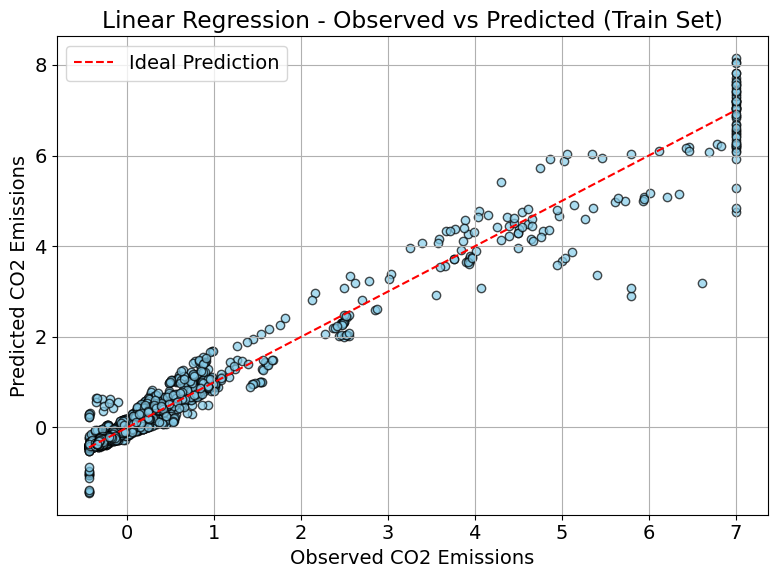

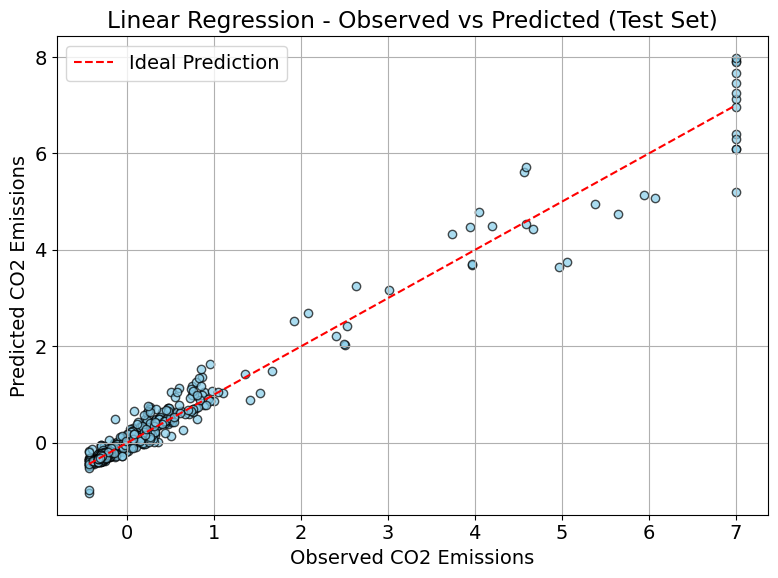

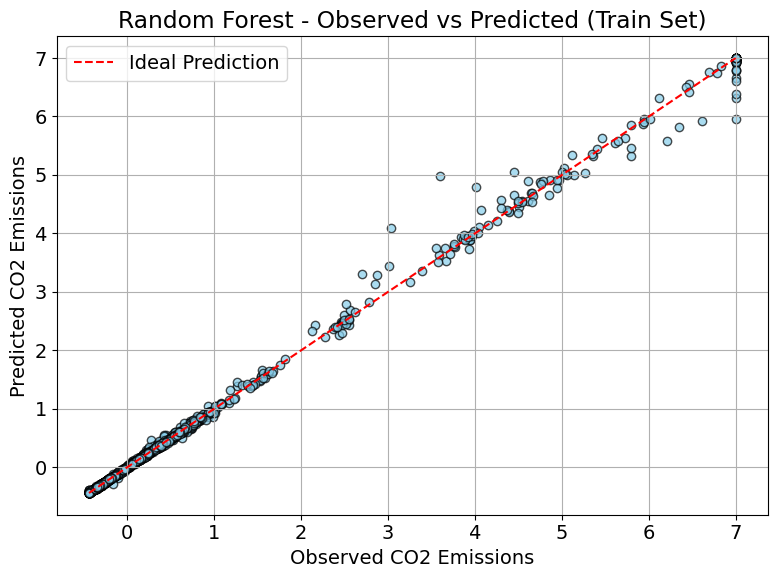

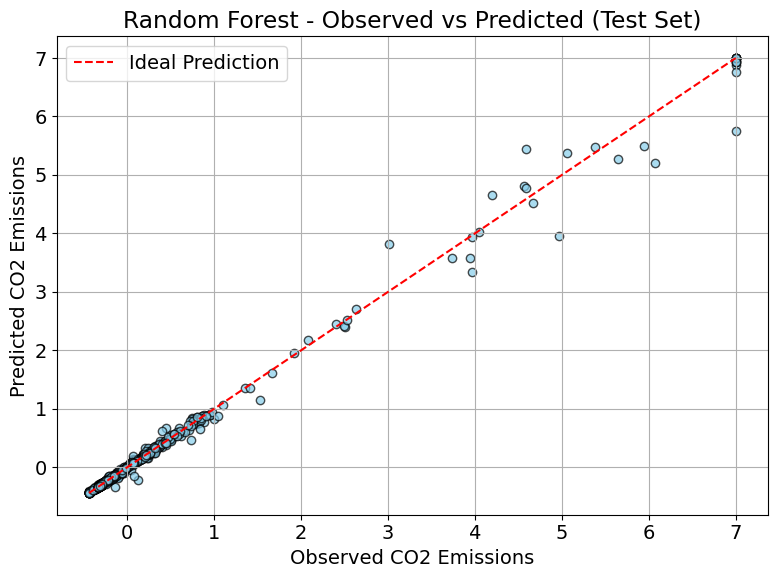

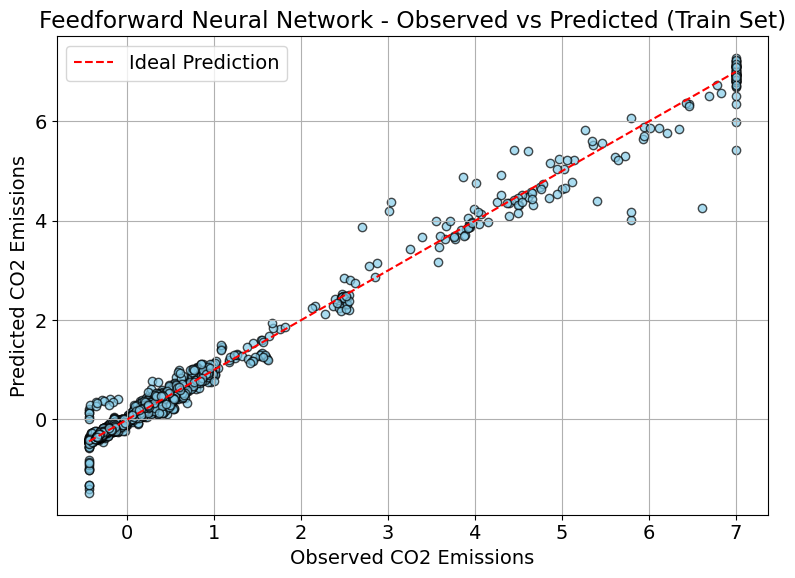

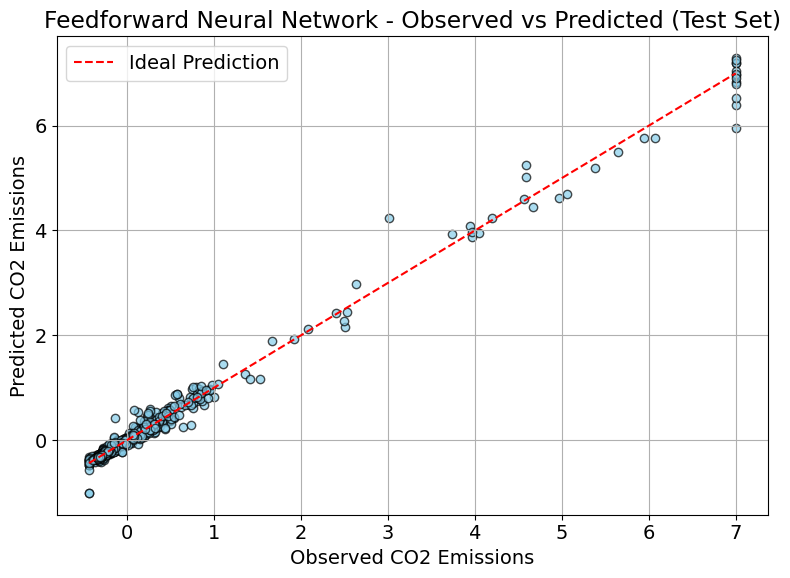

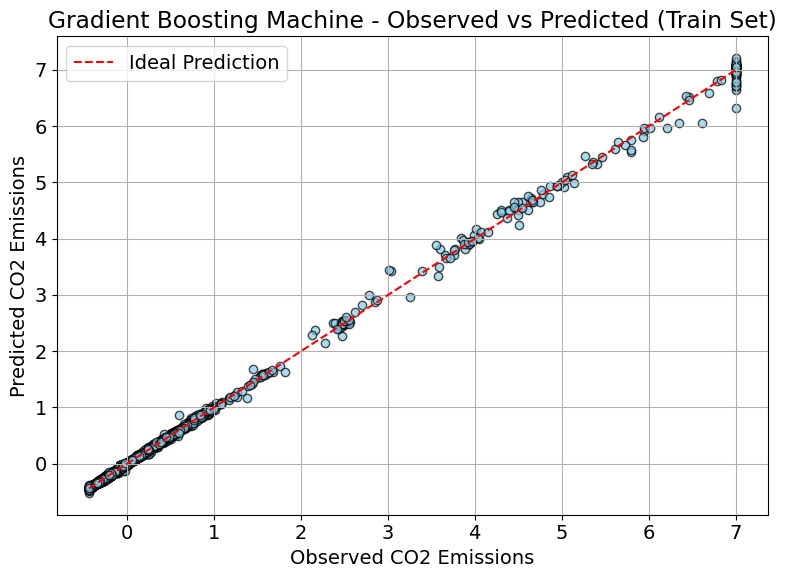

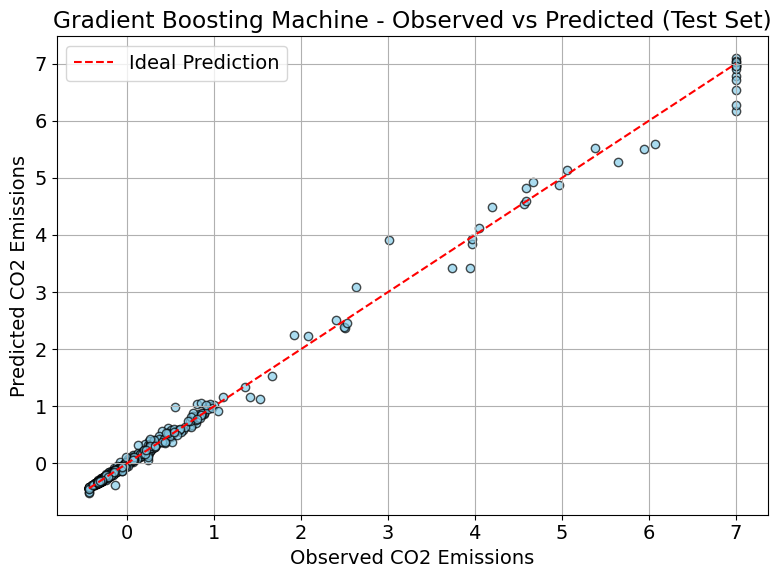

In [68]:
#Error analysis of observed and predicted CO2 emission for training (after hyperparameter tuning & feature selection) and test data 
def plot_scatter_observed_vs_predicted(model_name, y_actual, y_pred, set_type):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, color="skyblue", edgecolor="black")
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], color='red', linestyle='--', label="Ideal Prediction")
    plt.xlabel("Observed CO2 Emissions")
    plt.ylabel("Predicted CO2 Emissions")
    plt.title(f"{model_name} - Observed vs Predicted ({set_type} Set)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{model_name}_Observed_vs_Predicted_{set_type}.png", dpi=300)
    plt.show()

# Generate and save scatterplots for all models
for model_name, model in models.items():
    # Train set
    y_pred_train = model.predict(x_train_fs)
    plot_scatter_observed_vs_predicted(model_name, y_train_fs, y_pred_train, "Train")
    
    # Test set
    y_pred_test = model.predict(x_test_fs)
    plot_scatter_observed_vs_predicted(model_name, y_test_fs, y_pred_test, "Test")


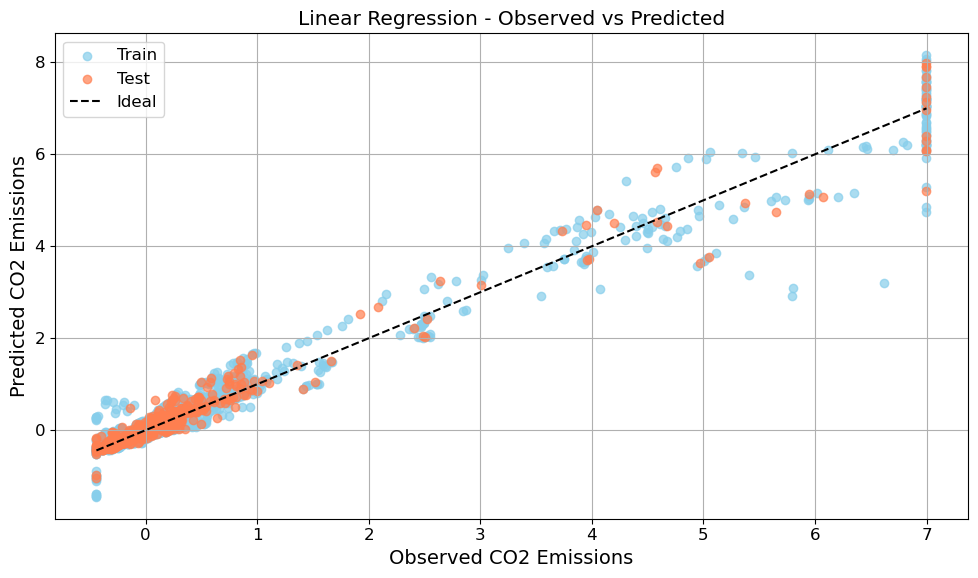

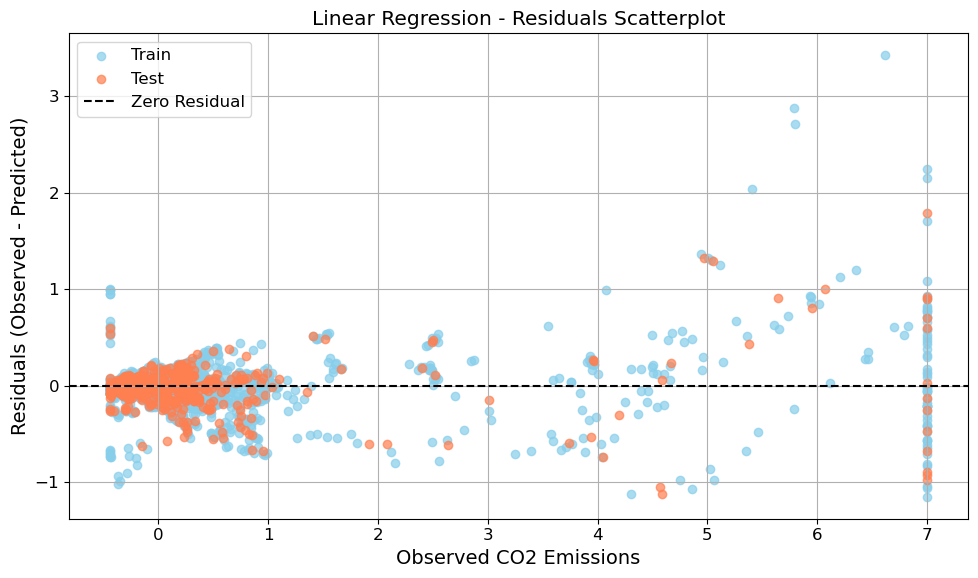

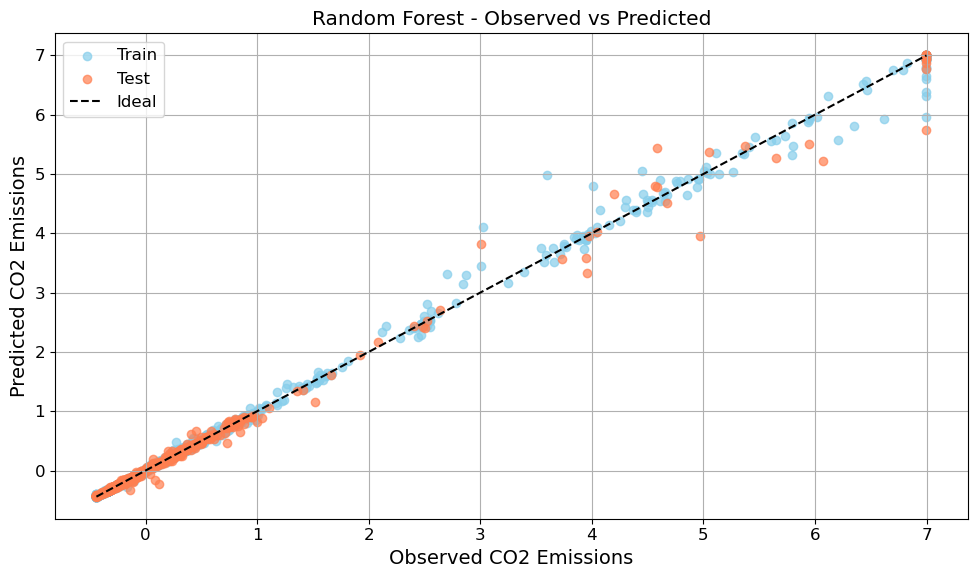

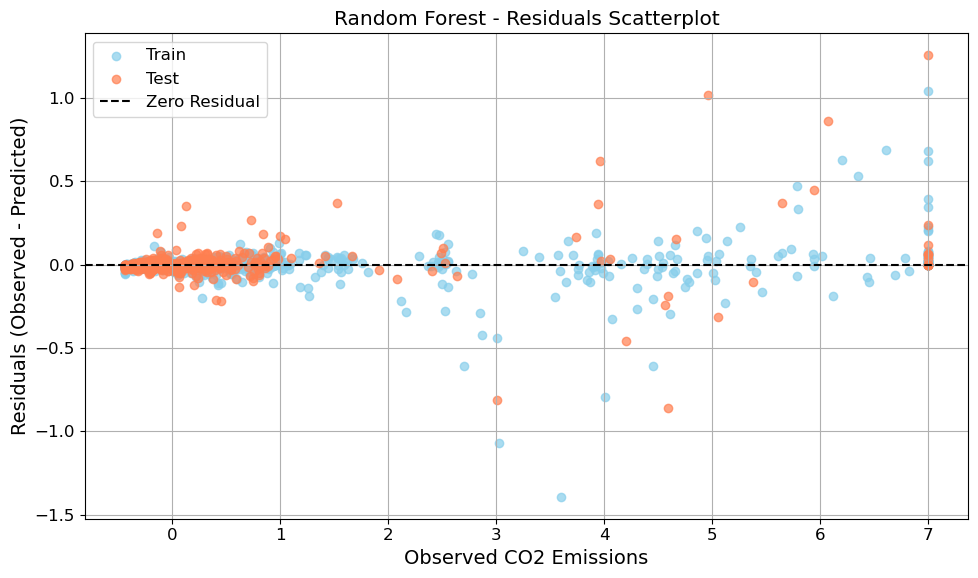

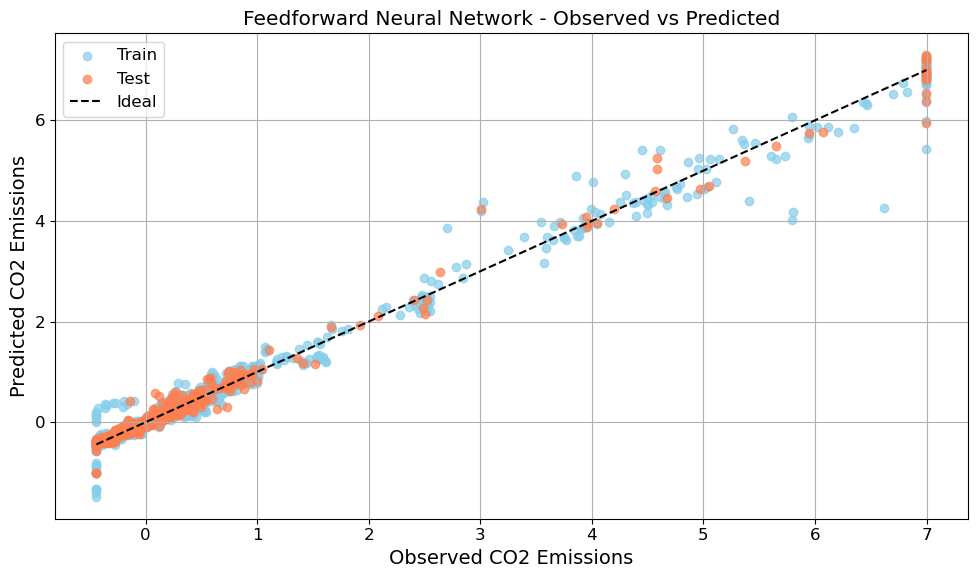

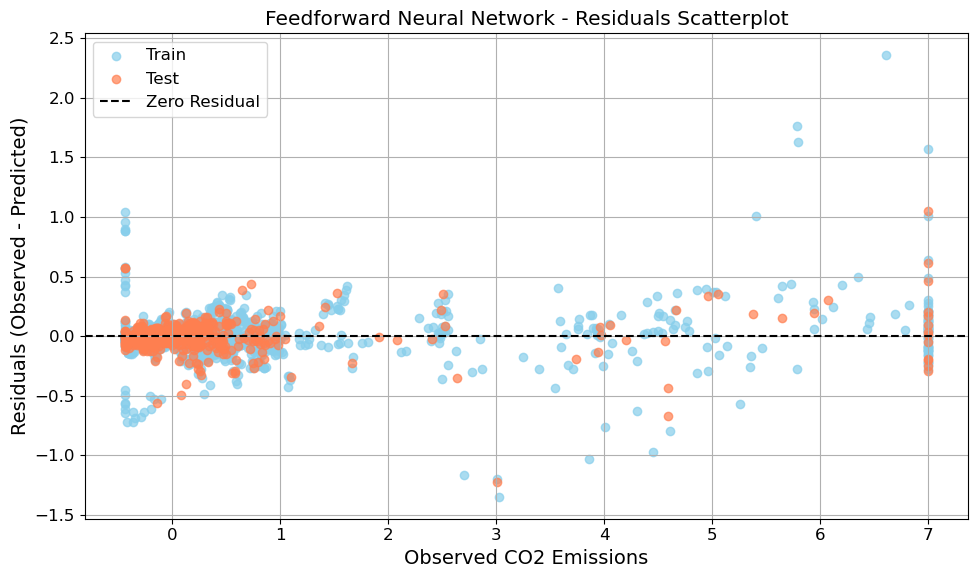

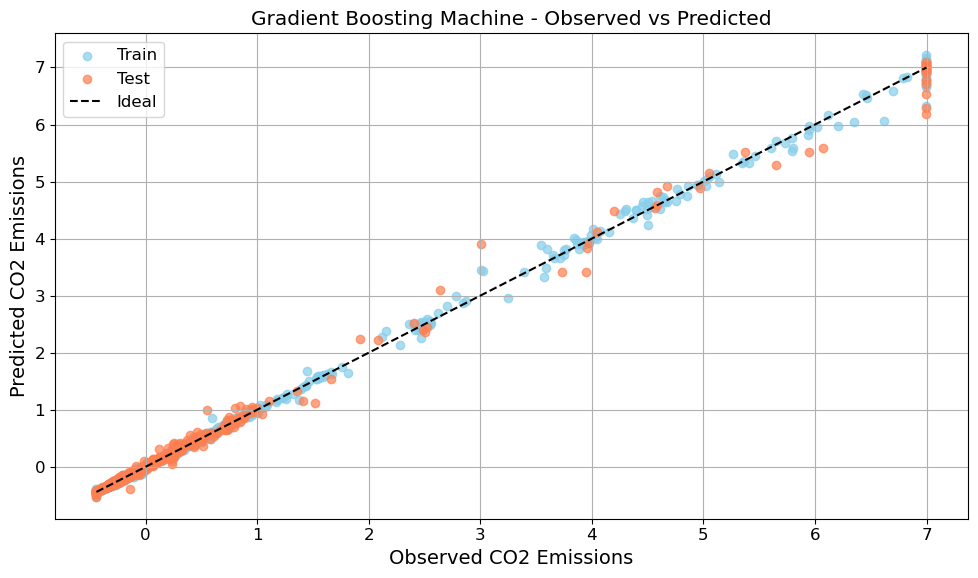

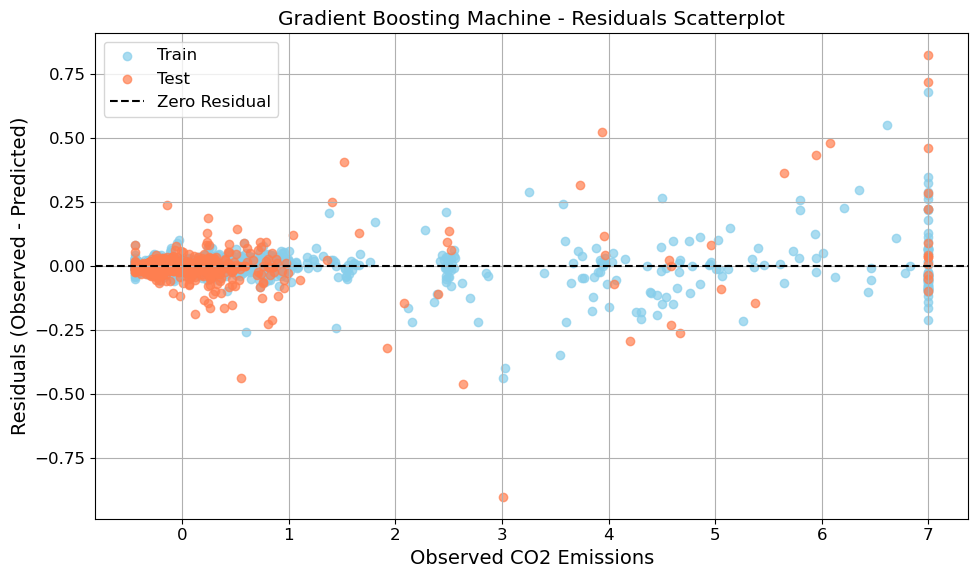


Error Analysis Summary:

Linear Regression:
  Train MSE: 0.0293
  Test MSE: 0.0240
  Train MAE: 0.0732
  Test MAE: 0.0694
  Train R²: 0.9717
  Test R²: 0.9720

Random Forest:
  Train MSE: 0.0019
  Test MSE: 0.0051
  Train MAE: 0.0077
  Test MAE: 0.0154
  Train R²: 0.9981
  Test R²: 0.9940

Feedforward Neural Network:
  Train MSE: 0.0106
  Test MSE: 0.0074
  Train MAE: 0.0411
  Test MAE: 0.0380
  Train R²: 0.9898
  Test R²: 0.9913

Gradient Boosting Machine:
  Train MSE: 0.0008
  Test MSE: 0.0038
  Train MAE: 0.0098
  Test MAE: 0.0184
  Train R²: 0.9992
  Test R²: 0.9956


In [75]:
# Perform error analysis for each model
error_analysis = {}
for model_name, model in models.items():
    # Predictions on the train set
    y_pred_train = model.predict(x_train_fs)
    residuals_train = y_train_fs - y_pred_train  # Residuals for training set
    
    # Predictions on the test set
    y_pred_test = model.predict(x_test_fs)
    residuals_test = y_test_fs - y_pred_test  # Residuals for test set

    # Compute error metrics
    mse_train = mean_squared_error(y_train_fs, y_pred_train)
    mae_train = mean_absolute_error(y_train_fs, y_pred_train)
    r2_train = r2_score(y_train_fs, y_pred_train)
    
    mse_test = mean_squared_error(y_test_fs, y_pred_test)
    mae_test = mean_absolute_error(y_test_fs, y_pred_test)
    r2_test = r2_score(y_test_fs, y_pred_test)
    
    # Store error metrics in dictionary
    error_analysis[model_name] = {
        "Train MSE": mse_train, "Test MSE": mse_test,
        "Train MAE": mae_train, "Test MAE": mae_test,
        "Train R²": r2_train, "Test R²": r2_test
    }

    # Plot observed vs. predicted for train and test sets
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_fs, y_pred_train, color="skyblue", alpha=0.7, label="Train")
    plt.scatter(y_test_fs, y_pred_test, color="coral", alpha=0.7, label="Test")
    plt.plot([y_train_fs.min(), y_train_fs.max()], [y_train_fs.min(), y_train_fs.max()], color='black', linestyle='--', label="Ideal")
    plt.xlabel("Observed CO2 Emissions", fontsize=14)
    plt.ylabel("Predicted CO2 Emissions", fontsize=14)
    plt.title(f"{model_name} - Observed vs Predicted", fontsize=14.5)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{model_name}_Observed_vs_Predicted.png", dpi=300)
    plt.show()

    # Plot residuals for training and test sets
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_fs, residuals_train, alpha=0.7, color="skyblue", label="Train")
    plt.scatter(y_test_fs, residuals_test, alpha=0.7, color="coral", label="Test")
    plt.axhline(0, color='black', linestyle='--', label="Zero Residual")
    plt.xlabel("Observed CO2 Emissions", fontsize=14)
    plt.ylabel("Residuals (Observed - Predicted)", fontsize=14)
    plt.title(f"{model_name} - Residuals Scatterplot", fontsize=14.5)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{model_name}_Residuals_Scatterplot.png", dpi=300)
    plt.show()

# Print the summary of error metrics
print("\nError Analysis Summary:")
for model_name, metrics in error_analysis.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
